# Times Series Modeling 
----

## Pre-Processing Data

In [214]:
import pandas as pd 
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, GRU
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import missingno as msno
from sklearn import metrics

In [215]:
covid = pd.read_csv('../data/clean_data/covid_cases_us_clean.csv')
covid['Date'] = pd.to_datetime(covid['Date'])
covid = covid[['Date','state','tot_cases','new_case','tot_death','new_death']]
covid.set_index('Date', inplace=True)
covid.sort_index(inplace=True)

In [216]:
covid

,state,tot_cases,new_case,tot_death,new_death
Date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [217]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [218]:
# Creating a copy of dataset to perform modeling
df = covid.copy()
df

,state,tot_cases,new_case,tot_death,new_death
Date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [219]:
df = df.groupby(by=df.index).sum()
df

/var/folders/f6/bcpr8m4x03z8f6wbw7mw1wm80000gq/T/ipykernel_19599/4010308680.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(by=df.index).sum()


,tot_cases,new_case,tot_death,new_death
Date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0
...,...,...,...,...
2022-10-07,96491443,42558,1057306,314
2022-10-08,96502884,11441,1057365,59
2022-10-09,96516506,13622,1057428,63


## Checking for Trends, Seasonality and Stationary on Data
---

We trying to build a Time Series on new Covid Cases so first we need to check for some assumptions like stationarity, trends and seasonalities on the dataset.

In [220]:
df_st = df.resample('W').mean()

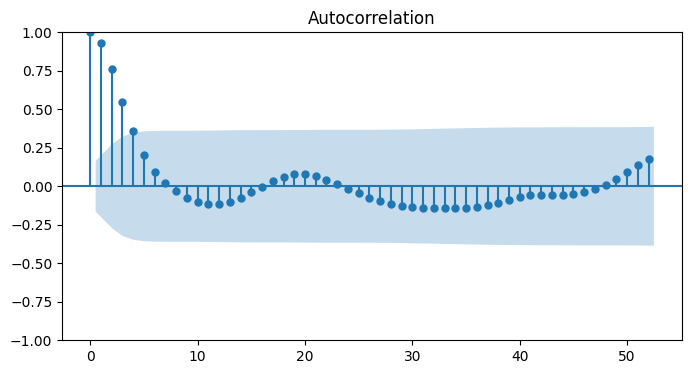

In [221]:
# Generate the ACF plot on Weekly data up to 52 time periods.
plt.rc("figure", figsize=(8,4))
plot_acf(df_st['new_case'], lags = 52);

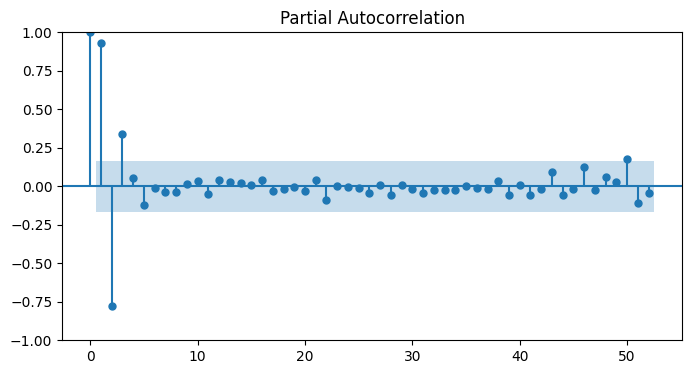

In [222]:
plt.rc("figure", figsize=(8,4))
plot_pacf(df_st['new_case'], lags = 52, method='ywm' );

Looking at the Autocorrelation and Partial Autocorrelation plots we couldn't find any trends/seasonality on the data. This means that the model will not perform as it should. 

Applying Dickey-Test to check our hypotesis:

In [223]:
# Run ADF test on original (non-differenced!) data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [224]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -4.085958
p-value           0.001022
dtype: float64

In [225]:
df.head()

,tot_cases,new_case,tot_death,new_death
Date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0


## 1. ARIMA Models

In [226]:
# dropping columns
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)
#df = df.resample('W').mean()

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   new_case  994 non-null    int64
dtypes: int64(1)
memory usage: 15.5 KB


In [228]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [229]:
# Checking train tail
y_train.tail()

Date
2022-06-29    152659
2022-06-30    118056
2022-07-01    173431
2022-07-02     51724
2022-07-03     47838
Name: new_case, dtype: int64

In [230]:
# Checking the test head
y_test.head()

Date
2022-07-04     46368
2022-07-05    170070
2022-07-06    146187
2022-07-07    120798
2022-07-08    180960
Name: new_case, dtype: int64

### 1.1. Building a ARIMA(0,1,0)

In [231]:
# Instantiate best model.
arima_010 = ARIMA(endog = y_train, order = (0, 1, 0))

# Fit ARIMA model.
model_010 = arima_010.fit()

# Generate predictions based on test set.
preds_010 = model_010.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_010 = model_010.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_010))

MSE:  4237225928.63


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


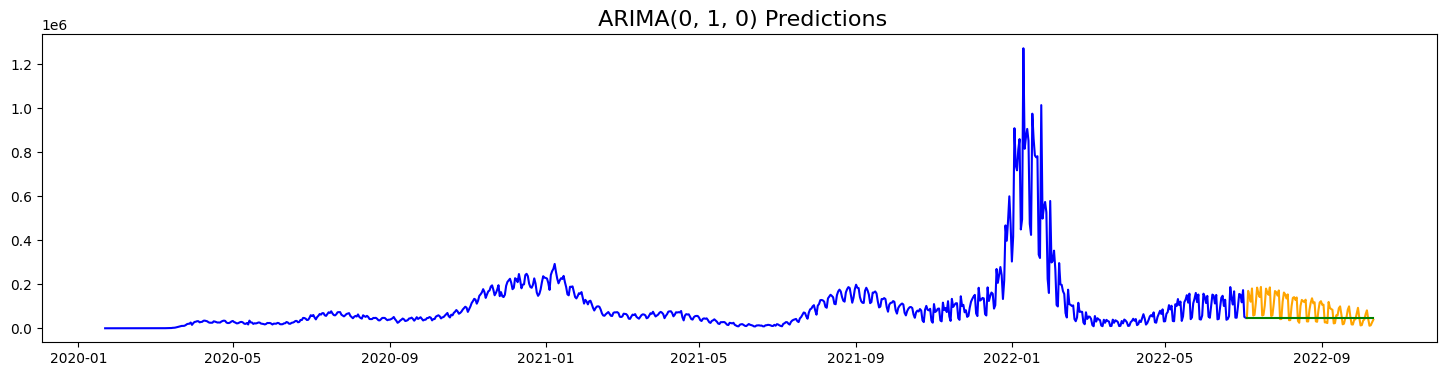

In [236]:
# Plotting the model ARIMA(0,1,0)
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_010, color = 'green')

plt.title(label = ' ARIMA(0, 1, 0) Predictions', fontsize=16);

### 1.2. Building a ARIMA(3,0,1)

In [237]:
# Instantiate best model.
arima_301 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_301 = arima_301.fit()

# Generate predictions based on test set.
preds_301 = model_301.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_301 = model_301.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_301))

MSE:  2791954341.418027


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
df_train = pd.DataFrame( y_train.values, y_train.index)
df_train = df_train.resample('W').mean()
df_test = pd.DataFrame( y_test.values, y_test.index)
df_test = df_test.resample('W').mean()
df_preds = pd.DataFrame(preds_301, y_test.index)
df_preds = df_preds.resample('W').mean()

<Figure size 1800x400 with 0 Axes>

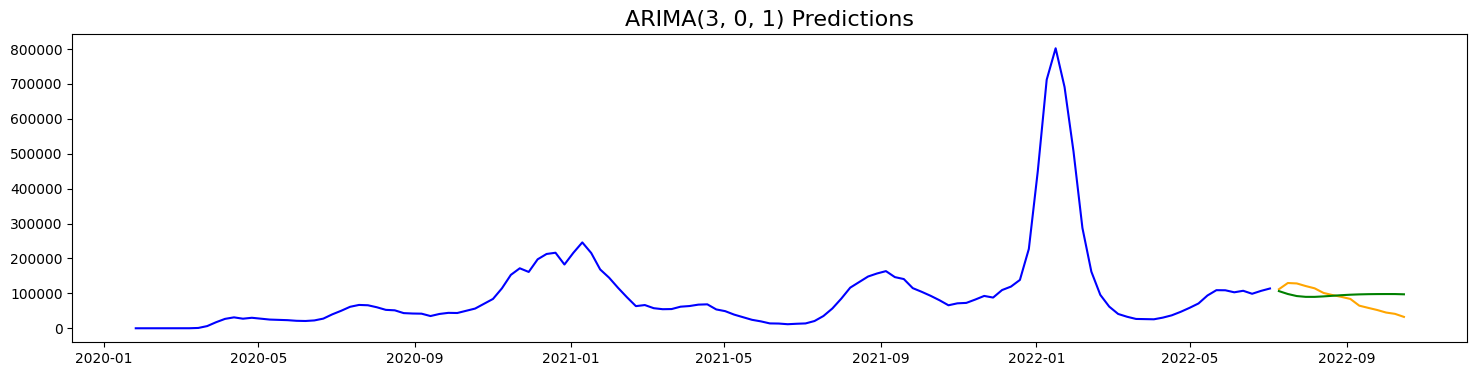

In [255]:
# Plotting  the model ARIMA(3,0,1).
plt.figure(figsize=(18,4))

plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(df_train.index, df_train, color = 'blue')

# Plot testing data.
plt.plot(df_test.index, df_test, color = 'orange')

# Plot predicted test values.
plt.plot(df_preds.index, df_preds, color = 'green')

plt.title(label = 'ARIMA(3, 0, 1) Predictions', fontsize=16);

### 1.3. Building a ARIMA(52, 0, 1)

In [256]:
# Instantiate best model.
arima_2201 = ARIMA(endog = y_train, order = (22, 0, 1))

# Fit ARIMA model.
model_2201 = arima_2201.fit()

# Generate predictions based on test set.
preds_2201 = model_2201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_2201 = model_2201.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_2201))

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE:  1681676724.374208


In [257]:
# Dataframe for plotting
df_train = pd.DataFrame( y_train.values, y_train.index)
df_train = df_train.resample('W').mean()
df_test = pd.DataFrame( y_test.values, y_test.index)
df_test = df_test.resample('W').mean()
df_preds = pd.DataFrame(preds_2201, y_test.index)
df_preds = df_preds.resample('W').mean()

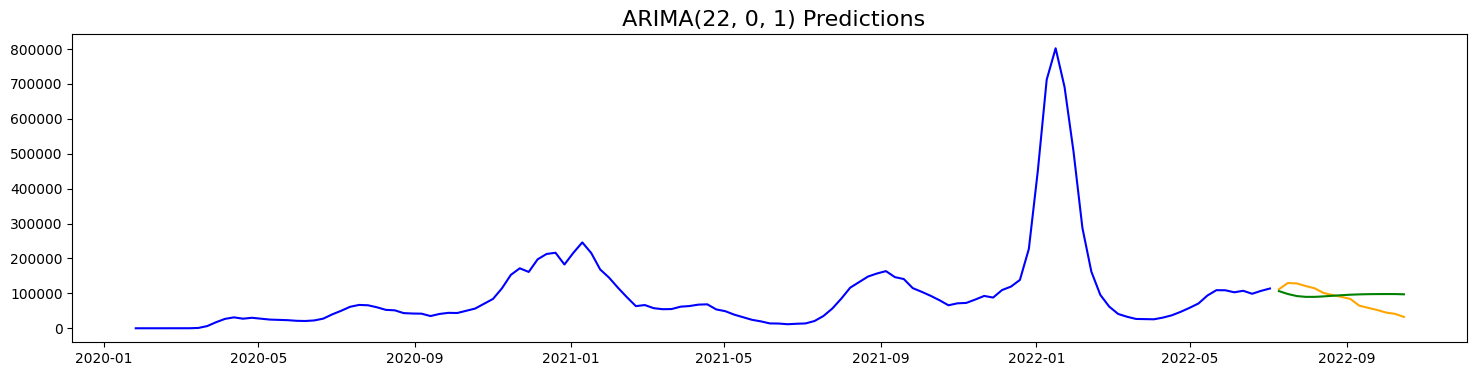

In [258]:
# Plotting  the model ARIMA(22,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(df_train.index, df_train, color = 'blue')

# Plot testing data.
plt.plot(df_test.index, df_test, color = 'orange')

# Plot predicted test values.
plt.plot(df_preds.index, df_preds, color = 'green')

plt.title(label = ' ARIMA(22, 0, 1) Predictions', fontsize=16);

## 2. SARIMA Models

### 2.1. SARIMA(3, 0, 1) x (1, 1, 1, 22)

In [263]:
# Fit a SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1, 1, 1, 22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24326D+01    |proj g|=  5.55263D-01


 This problem is unconstrained.



At iterate    5    f=  1.21778D+01    |proj g|=  1.68809D-01

At iterate   10    f=  1.21464D+01    |proj g|=  1.66225D-02

At iterate   15    f=  1.21448D+01    |proj g|=  4.71760D-03

At iterate   20    f=  1.21425D+01    |proj g|=  1.99926D-03

At iterate   25    f=  1.21425D+01    |proj g|=  7.00520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     31      1     0     0   8.821D-06   1.214D+01
  F =   12.142457021424025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


3638844274.47089

In [264]:
df_train = pd.DataFrame( y_train.values, y_train.index)
df_train = df_train.resample('W').mean()
df_test = pd.DataFrame( y_test.values, y_test.index)
df_test = df_test.resample('W').mean()
df_preds = pd.DataFrame(preds_sarima, y_test.index)
df_preds = df_preds.resample('W').mean()

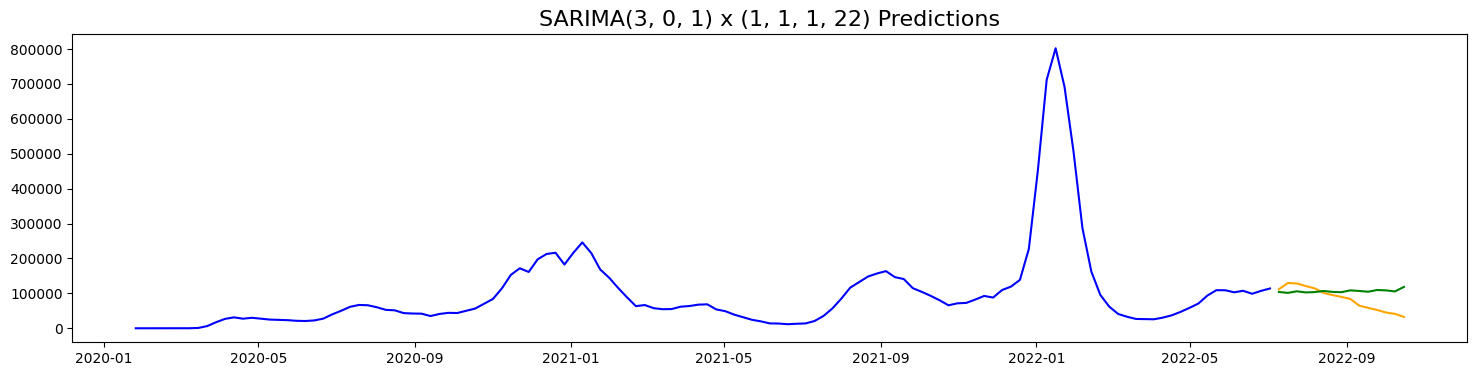

In [265]:
# Plotting SARIMA
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(df_train.index, df_train, color = 'blue')

# Plot testing data.
plt.plot(df_test.index, df_test, color = 'orange')

# Plot predicted test values.
plt.plot(df_preds.index, df_preds, color = 'green')

plt.title(label = 'SARIMA(3, 0, 1) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

### 2.2. SARIMA(1, 0, 0) x (1, 1, 1, 22) (GridSearch Parameters)

In [270]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [271]:
y_train.tail()

Date
2022-06-29    152659
2022-06-30    118056
2022-07-01    173431
2022-07-02     51724
2022-07-03     47838
Name: new_case, dtype: int64

In [272]:
y_test.head()

Date
2022-07-04     46368
2022-07-05    170070
2022-07-06    146187
2022-07-07    120798
2022-07-08    180960
Name: new_case, dtype: int64

In [304]:
# Fit SARIMA model. SARIMA(1, 0, 1)x(2,0,1,22)
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 1),                # (p, d, q)
                  seasonal_order=(2,0,1,22))       # (P, D, Q, S)


model_sarima = sarima.fit()

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31844D+01    |proj g|=  1.47138D+00


 This problem is unconstrained.



At iterate    5    f=  1.23715D+01    |proj g|=  6.56553D-03

At iterate   10    f=  1.23670D+01    |proj g|=  2.26295D-02

At iterate   15    f=  1.23652D+01    |proj g|=  3.83972D-03

At iterate   20    f=  1.23650D+01    |proj g|=  3.56092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   8.121D-06   1.237D+01
  F =   12.365038359736033     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [303]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

9691694917.022123

In [286]:
#2022-07-10    111881.000000
#2022-07-17    129685.285714
#2022-07-24    128469.285714
#2022-07-31    120971.000000
#2022-08-07    114476.428571
print(model_sarima.predict('2022-07-10'))
print(y_test['2022-07-10'])
print(model_sarima.predict(pd.to_datetime('2022-07-17')))
print(y_test['2022-07-17'])
print(model_010.predict('2022-07-24'))
print(y_test['2022-07-24'])


2022-07-10    24591.375599
Freq: D, dtype: float64
60706
2022-07-17    8792.765159
Freq: D, dtype: float64
60483
2022-07-24    47838.0
Freq: D, dtype: float64
58652


In [287]:
df_train = pd.DataFrame( y_train.values, y_train.index)
df_train = df_train.resample('W').mean()
df_test = pd.DataFrame( y_test.values, y_test.index)
df_test = df_test.resample('W').mean()
df_preds = pd.DataFrame(preds_sarima, y_test.index)
df_preds = df_preds.resample('W').mean()

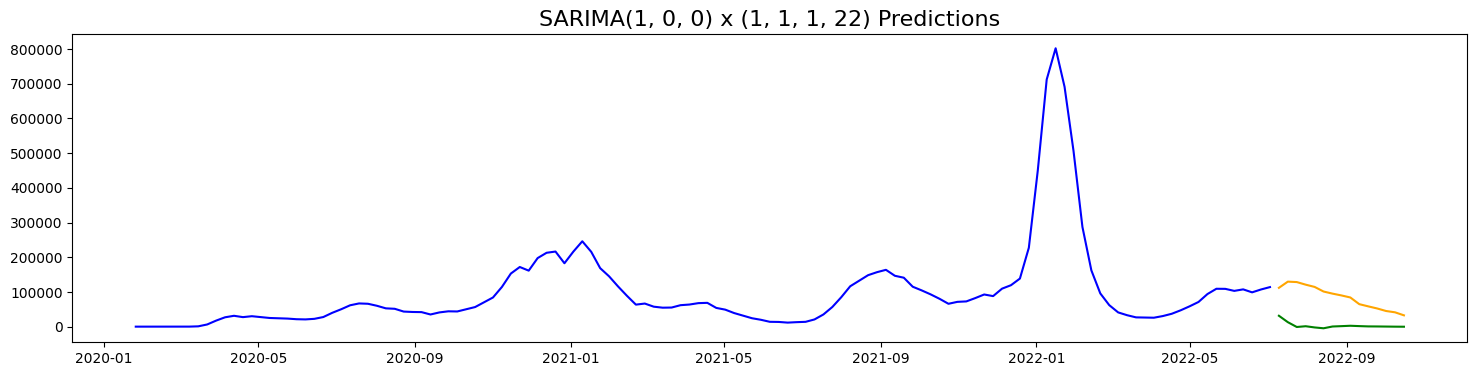

In [288]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(df_train.index, df_train, color = 'blue')

# Plot testing data.
plt.plot(df_test.index, df_test, color = 'orange')

# Plot predicted test values.
plt.plot(df_preds.index, df_preds, color = 'green')

plt.title(label = 'SARIMA(1, 0, 0) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

In [290]:
# Starting MSE and (P, D, Q).
def my_gridsearch():
    mse = 99 * (10 ** 16)
    final_p = 0
    final_d = 0
    final_q = 0
    final_P = 0
    final_D = 0
    final_Q = 0

    for p in range(2):
        for q in range(2):
            for d in range(2):
                for P in range(3):
                    for Q in range(3):
                        for D in range(3):
                            try:
                                sarima = SARIMAX(endog = y_train,
                                                order = (p, d, q),              # (p, d, q)
                                                seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                                
                                print(P, D, Q)
                                # Fit SARIMA model.
                                model = sarima.fit()
                                preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
                                print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')#

                                                # Save for final report.
                                if mse > metrics.mean_squared_error(y_test, preds_sarima):
                                    mse = metrics.mean_squared_error(y_test, preds_sarima)
                                    
                                    final_p = p
                                    final_d = d
                                    final_q = q
                                    final_P = P
                                    final_D = D
                                    final_Q = Q
                            except:

                                    pass
        print(f'Our model that minimizes MSE on the training data is the SARIMA({final_p }, {final_d}, {final_q})x({final_P},{final_D},{final_Q},22).')
        print(f'This model has an MSE of {mse}.')
    return print('Gridsearach Done!')

In [293]:
# 39 minutes to perform this gridsearch 
#my_gridsearch()

# Output: 
# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(2,0,1,22).
# This model has an MSE of 2571443308.2852535.
# Gridsearach Done!


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs

0 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34428D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.344D+01
  F =   13.442775422087136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,0,0,22) is: 10301975443.79
0 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


The MSE for (0, 0, 0)x(0,0,1,22) is: 8743142770.617085
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29746D+01    |proj g|=  1.81280D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.29313D+01    |proj g|=  8.64198D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   8.642D-07   1.293D+01
  F =   12.931292497063207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,1,1,22) is: 4331206475.827549
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28935D+01    |proj g|=  1.68290D-01


 This problem is unconstrained.



At iterate    5    f=  1.28015D+01    |proj g|=  1.50713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     10      1     0     0   2.409D-06   1.280D+01
  F =   12.801249143618694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,2,1,22) is: 7323228018.322116
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33660D+01    |proj g|=  1.94102D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.32770D+01    |proj g|=  7.00760D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   2.647D-06   1.328D+01
  F =   13.277047751311885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,0,2,22) is: 7765794285.43747
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30335D+01    |proj g|=  3.20203D-01


 This problem is unconstrained.



At iterate    5    f=  1.28613D+01    |proj g|=  4.45462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   3.421D-06   1.286D+01
  F =   12.861173675626667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,1,2,22) is: 4857970627.968973
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30233D+01    |proj g|=  3.56374D-01

At iterate    5    f=  1.28207D+01    |proj g|=  1.38311D-02

At iterate   10    f=  1.28165D+01    |proj g|=  4.29090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   2.499D-06   1.282D+01
  F =   12.816525802438404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(0,2,2,22) is: 6168186468.974668
1 0 0
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (0, 0, 0)x(1,1,0,22) is: 6106487453.749767
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29191D+01    |proj g|=  3.45555D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.456D-06   1.292D+01
  F =   12.919116524317287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,2,0,22) is: 30678612558.779766
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (0, 0, 0)x(1,0,1,22) is: 5871140250.056256
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29707D+01    |proj g|=  1.95017D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.29446D+01    |proj g|=  1.50063D-01

At iterate   10    f=  1.28649D+01    |proj g|=  4.29978D-02

At iterate   15    f=  1.28570D+01    |proj g|=  1.49455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   1.869D-06   1.286D+01
  F =   12.856985360089242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,1,1,22) is: 4197339656.735994
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29206D+01    |proj g|=  1.53989D-01

At iterate    5    f=  1.27507D+01    |proj g|=  5.02976D-03

At iterate   10    f=  1.27490D+01    |proj g|=  3.98970D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   3.990D-06   1.275D+01
  F =   12.749021796654503     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,2,1,22) is: 6960979722.192221
1 0 2
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.31803D+01    |proj g|=  3.07653D-02

At iterate   10    f=  1.31607D+01    |proj g|=  2.36791D-02

At iterate   15    f=  1.31528D+01    |proj g|=  3.03299D-03

At iterate   20    f=  1.31524D+01    |proj g|=  2.57199D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   2.572D-06   1.315D+01
  F =   13.152355349012087     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,0,2,22) is: 3304898751.412344
1 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30803D+01    |proj g|=  6.32728D-01

At iterate    5    f=  1.28910D+01    |proj g|=  3.49292D-02

At iterate   10    f=  1.28576D+01    |proj g|=  2.77521D-02

At iterate   15    f=  1.28564D+01    |proj g|=  7.85629D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   8.951D-06   1.286D+01
  F =   12.856442888797888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29234D+01    |proj g|=  3.33186D-01


 This problem is unconstrained.



At iterate    5    f=  1.27653D+01    |proj g|=  3.09746D-03

At iterate   10    f=  1.27650D+01    |proj g|=  2.33096D-04

At iterate   15    f=  1.27650D+01    |proj g|=  1.19255D-03

At iterate   20    f=  1.27649D+01    |proj g|=  1.38062D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     23      1     0     0   9.786D-06   1.276D+01
  F =   12.764938039381896     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(1,2,2,22) is: 7247275722.076118
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (0, 0, 0)x(2,0,0,22) is: 5708652452.156565
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29046D+01    |proj g|=  6.76123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   1.570D-05   1.290D+01
  F =   12.904610332794716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 0)x(2,1,0,22) is: 5272562928.851818
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28345D+01    |proj g|=  4.91545D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   2.032D-05   1.283D+01
  F =   12.834543537319515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 0)x(2,2,0,22) is: 25258693379.88267
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 va

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.31754D+01    |proj g|=  4.98513D-03

At iterate   10    f=  1.31738D+01    |proj g|=  2.43809D-03

At iterate   15    f=  1.31738D+01    |proj g|=  5.80082D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   1.187D-06   1.317D+01
  F =   13.173804499412290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(2,0,1,22) is: 5694281244.590976
2 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29677D+01    |proj g|=  4.18810D-01


 This problem is unconstrained.



At iterate    5    f=  1.29071D+01    |proj g|=  1.35094D-01

At iterate   10    f=  1.28468D+01    |proj g|=  5.95507D-02

At iterate   15    f=  1.28312D+01    |proj g|=  6.64573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.731D-06   1.283D+01
  F =   12.831205932616852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(2,1,1,22) is: 4728310034.169926
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28646D+01    |proj g|=  2.24605D-01

At iterate    5    f=  1.27947D+01    |proj g|=  2.92063D-01

At iterate   10    f=  1.26973D+01    |proj g|=  1.71882D-02

At iterate   15    f=  1.26914D+01    |proj g|=  1.00681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   2.213D-06   1.269D+01
  F =   12.691350520418883     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34563D+01    |proj g|=  7.96633D-01

At iterate    5    f=  1.31804D+01    |proj g|=  2.27654D-02

At iterate   10    f=  1.31742D+01    |proj g|=  2.24050D-02

At iterate   15    f=  1.31601D+01    |proj g|=  1.78616D-02

At iterate   20    f=  1.31498D+01    |proj g|=  5.79504D-03

At iterate   25    f=  1.31490D+01    |proj g|=  1.62087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30387D+01    |proj g|=  5.87550D-01

At iterate    5    f=  1.28620D+01    |proj g|=  7.97948D-02

At iterate   10    f=  1.28514D+01    |proj g|=  4.01156D-03

At iterate   15    f=  1.28470D+01    |proj g|=  2.83239D-02

At iterate   20    f=  1.28424D+01    |proj g|=  2.18686D-03

At iterate   25    f=  1.28424D+01    |proj g|=  1.16881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28899D+01    |proj g|=  6.04120D-01


 This problem is unconstrained.



At iterate    5    f=  1.27237D+01    |proj g|=  1.48232D-02

At iterate   10    f=  1.27208D+01    |proj g|=  3.31869D-03

At iterate   15    f=  1.27065D+01    |proj g|=  8.61248D-02

At iterate   20    f=  1.26868D+01    |proj g|=  9.25041D-03

At iterate   25    f=  1.26858D+01    |proj g|=  1.10146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     38      1     0     0   3.288D-06   1.269D+01
  F =   12.685776059901670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 0)x(2,2,2,22) is: 7756760252.710213
0 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs

The MSE for (0, 1, 0)x(0,2,0,22) is: 1016972512203.8553
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25598D+01    |proj g|=  3.09107D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.790D-06   1.248D+01
  F =   12.484669283650401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (0, 1, 0)x(0,0,1,22) is: 4523896559.834136
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25883D+01    |proj g|=  5.36099D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  1.23230D+01    |proj g|=  4.76223D-03

At iterate   10    f=  1.23220D+01    |proj g|=  5.06173D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     11      1     0     0   5.062D-06   1.232D+01
  F =   12.321985076690394     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,1,1,22) is: 3275794189.0745792
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28034D+01    |proj g|=  6.99603D-01

At iterate    5    f=  1.24701D+01    |proj g|=  6.56552D-03

At iterate   10    f=  1.24682D+01    |proj g|=  5.24327D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     11      1     0     0   5.243D-06   1.247D+01
  F =   12.468191287507894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,2,1,22) is: 10122216289.832623
0 0 2
RUNNING 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24839D+01    |proj g|=  1.54149D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      6      1     0     0   1.541D-05   1.248D+01
  F =   12.483881096030375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(0,0,2,22) is: 4114000933.613287
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25863D+01    |proj g|=  4.91834D-01


 This problem is unconstrained.



At iterate    5    f=  1.23403D+01    |proj g|=  7.26605D-03

At iterate   10    f=  1.23383D+01    |proj g|=  5.34825D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   5.348D-06   1.234D+01
  F =   12.338295506205615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,1,2,22) is: 3320000171.174222
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24264D+01    |proj g|=  1.42312D-02

At iterate    5    f=  1.24210D+01    |proj g|=  5.01828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   4.435D-06   1.242D+01
  F =   12.420950230026987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(0,2,2,22) is: 11370908922.53663
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24405D+01    |proj g|=  3.57119D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.571D-06   1.244D+01
  F =   12.440526210749139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,1,0,22) is: 13638954526.528713
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25368D+01    |proj g|=  1.81650D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   1.817D-06   1.254D+01
  F =   12.536825969006404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


The MSE for (0, 1, 0)x(1,2,0,22) is: 25418428876.612373
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25564D+01    |proj g|=  3.95309D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24819D+01    |proj g|=  1.98985D-02

At iterate   10    f=  1.24813D+01    |proj g|=  4.46594D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.466D-06   1.248D+01
  F =   12.481291927046486     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,0,1,22) is: 4336127832.63199
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23112D+01    |proj g|=  1.16646D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.22729D+01    |proj g|=  4.32471D-03

At iterate   10    f=  1.22719D+01    |proj g|=  2.50743D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   4.427D-06   1.227D+01
  F =   12.271934659760253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,1,1,22) is: 3424282190.7293353
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22867D+01    |proj g|=  2.22756D-02

At iterate    5    f=  1.22851D+01    |proj g|=  2.97659D-03

At iterate   10    f=  1.22833D+01    |proj g|=  4.92467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.901D-06   1.228D+01
  F =   12.283262222869812     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(1,2,1,22) is: 15364610630.271914
1 0 2
RUNNING 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24844D+01    |proj g|=  1.29589D-03

At iterate   10    f=  1.24838D+01    |proj g|=  1.70405D-02

At iterate   15    f=  1.24836D+01    |proj g|=  3.24458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.889D-05   1.248D+01
  F =   12.483559183283312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(1,0,2,22) is: 4100836181.1931806
1 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24416D+01    |proj g|=  3.33506D-01

At iterate    5    f=  1.22878D+01    |proj g|=  3.79342D-03

At iterate   10    f=  1.22876D+01    |proj g|=  3.27757D-03

At iterate   15    f=  1.22864D+01    |proj g|=  3.54892D-02

At iterate   20    f=  1.22779D+01    |proj g|=  6.26707D-03

At iterate   25    f=  1.22777D+01    |proj g|=  5.94742D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25382D+01    |proj g|=  3.43580D-01

At iterate    5    f=  1.23095D+01    |proj g|=  5.40878D-02

At iterate   10    f=  1.22590D+01    |proj g|=  1.98479D-02

At iterate   15    f=  1.22553D+01    |proj g|=  1.88845D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   4.901D-06   1.226D+01
  F =   12.255155579582226     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   7.455D-07   1.248D+01
  F =   12.479797680245696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,0,0,22) is: 4074990308.8263674
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23523D+01    |proj g|=  8.97243D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   8.772D-05   1.235D+01
  F =   12.352227400553293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(2,1,0,22) is: 6982771312.988713
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23734D+01    |proj g|=  4.94182D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.942D-06   1.237D+01
  F =   12.373420229530575     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,2,0,22) is: 29834115457.745937
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24800D+01    |proj g|=  4.30403D-03

At iterate   10    f=  1.24797D+01    |proj g|=  2.96700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   4.758D-06   1.248D+01
  F =   12.479724360063660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,0,1,22) is: 4081686181.145885
2 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23248D+01    |proj g|=  2.29000D-01

At iterate    5    f=  1.22555D+01    |proj g|=  1.18824D-01

At iterate   10    f=  1.22415D+01    |proj g|=  6.38109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   4.235D-05   1.224D+01
  F =   12.241469142473356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(2,1,1,22) is: 3127239881.2232585
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22380D+01    |proj g|=  1.01798D-01


 This problem is unconstrained.



At iterate    5    f=  1.21768D+01    |proj g|=  9.73031D-03

At iterate   10    f=  1.21753D+01    |proj g|=  2.19945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   4.090D-06   1.218D+01
  F =   12.175295217743265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,2,1,22) is: 7987088929.278596
2 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26341D+01    |proj g|=  5.61764D-01

At iterate    5    f=  1.24852D+01    |proj g|=  4.51663D-03

At iterate   10    f=  1.24833D+01    |proj g|=  2.25963D-03

At iterate   15    f=  1.24832D+01    |proj g|=  8.85285D-03

At iterate   20    f=  1.24831D+01    |proj g|=  8.41290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   8.549D-05   1.248D+01
  F =   12.483078442083116     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22806D+01    |proj g|=  1.28539D-01


 This problem is unconstrained.



At iterate    5    f=  1.22559D+01    |proj g|=  6.94485D-03

At iterate   10    f=  1.22508D+01    |proj g|=  3.14082D-02

At iterate   15    f=  1.22500D+01    |proj g|=  1.61331D-03

At iterate   20    f=  1.22496D+01    |proj g|=  5.75674D-03

At iterate   25    f=  1.22495D+01    |proj g|=  2.96773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   7.338D-06   1.225D+01
  F =   12.249458753022447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 0)x(2,1,2,22) is: 3028426213.709494
2 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23751D+01    |proj g|=  2.45875D-01


 This problem is unconstrained.



At iterate    5    f=  1.22146D+01    |proj g|=  1.55356D-02

At iterate   10    f=  1.21594D+01    |proj g|=  2.48022D-02

At iterate   15    f=  1.21575D+01    |proj g|=  1.72838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.652D-05   1.216D+01
  F =   12.157511041357516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 0)x(2,2,2,22) is: 3762832305.914731
0 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.27489D+01    |proj g|=  1.91101D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   2.609D-06   1.275D+01
  F =   12.748866816904455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,1,0,22) is: 6310335354.947274
0 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29050D+01    |proj g|=  2.37404D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.28698D+01    |proj g|=  1.28147D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.281D-06   1.287D+01
  F =   12.869823801987286     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,2,0,22) is: 54585879265.06473
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31586D+01    |proj g|=  2.49061D-01

At iterate    5    f=  1.30967D+01    |proj g|=  1.14194D-02

At itera

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


The MSE for (0, 0, 1)x(0,0,1,22) is: 9058028674.43677
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28125D+01    |proj g|=  2.11408D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.26599D+01    |proj g|=  1.61026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   4.038D-06   1.266D+01
  F =   12.659864389902822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,1,1,22) is: 5202003088.892726
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27895D+01    |proj g|=  1.98336D-01

At iterate    5    f=  1.26839D+01    |proj g|=  2.13772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   7.598D-06   1.268D+01
  F =   12.683673356682711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,2,1,22) is: 7192689045.666407
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.30884D+01    |proj g|=  8.95380D-03

At iterate   10    f=  1.30866D+01    |proj g|=  4.13003D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.130D-06   1.309D+01
  F =   13.086592444048499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,0,2,22) is: 8008655980.415899
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29113D+01    |proj g|=  3.48891D-01

At iterate    5    f=  1.26557D+01    |proj g|=  2.80949D-02

At iterate   10    f=  1.26548D+01    |proj g|=  3.69873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   4.128D-06   1.265D+01
  F =   12.654793762128525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,1,2,22) is: 5105507342.806334
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29050D+01    |proj g|=  3.57989D-01

At iterate    5    f=  1.26615D+01    |proj g|=  1.14941D-02

At iterate   10    f=  1.26565D+01    |proj g|=  1.23503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   9.944D-06   1.266D+01
  F =   12.656498675991301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(0,2,2,22) is: 4624303099.054527
1 0 0
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27734D+01    |proj g|=  2.17095D-01

At iterate    5    f=  1.27073D+01    |proj g|=  2.27254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   3.212D-06   1.271D+01
  F =   12.707238369439080     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,1,0,22) is: 5649542978.872811
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28198D+01    |proj g|=  2.43142D-01

At iterate    5    f=  1.27558D+01    |proj g|=  5.02596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   2.361D-06   1.276D+01
  F =   12.755751853649487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,2,0,22) is: 28937772406.16917
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.30789D+01    |proj g|=  2.82983D-03

At iterate   15    f=  1.30788D+01    |proj g|=  5.22782D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   5.228D-06   1.308D+01
  F =   13.078754896046442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,0,1,22) is: 3170981235.6820283
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28106D+01    |proj g|=  2.20829D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.26894D+01    |proj g|=  7.57898D-02

At iterate   10    f=  1.26588D+01    |proj g|=  8.81356D-03

At iterate   15    f=  1.26545D+01    |proj g|=  1.73127D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   1.731D-05   1.265D+01
  F =   12.654464374384135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 0, 1)x(1,1,1,22) is: 5040456642.73994
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28198D+01    |proj g|=  2.43132D-01


 This problem is unconstrained.



At iterate    5    f=  1.26669D+01    |proj g|=  4.37770D-03

At iterate   10    f=  1.26662D+01    |proj g|=  6.56176D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   4.698D-06   1.267D+01
  F =   12.666151350297838     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,2,1,22) is: 6310113960.474142
1 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33767D+01    |proj g|=  3.22151D-01

At iterate    5    f=  1.30866D+01    |proj g|=  1.31150D-02

At iterate   10    f=  1.30788D+01    |proj g|=  7.83575D-03

At iterate   15    f=  1.30749D+01    |proj g|=  1.15315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   4.932D-06   1.307D+01
  F =   13.074840737148655     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29582D+01    |proj g|=  7.01370D-01

At iterate    5    f=  1.26612D+01    |proj g|=  9.74168D-03

At iterate   10    f=  1.26585D+01    |proj g|=  3.49850D-03

At iterate   15    f=  1.26562D+01    |proj g|=  1.50521D-02

At iterate   20    f=  1.26545D+01    |proj g|=  1.41602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   4.333D-06   1.265D+01
  F =   12.654463321024934     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28195D+01    |proj g|=  2.44134D-01


 This problem is unconstrained.



At iterate    5    f=  1.26757D+01    |proj g|=  4.44596D-03

At iterate   10    f=  1.26567D+01    |proj g|=  4.14310D-03

At iterate   15    f=  1.26556D+01    |proj g|=  8.70111D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   3.474D-06   1.266D+01
  F =   12.655640704083979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(1,2,2,22) is: 4194872252.1843343
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.30826D+01    |proj g|=  1.70225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   4.187D-06   1.308D+01
  F =   13.082528991948129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,0,0,22) is: 6292851784.415631
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27540D+01    |proj g|=  1.78565D-01


 This problem is unconstrained.



At iterate    5    f=  1.26936D+01    |proj g|=  3.73054D-03

At iterate   10    f=  1.26935D+01    |proj g|=  3.42038D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   3.420D-06   1.269D+01
  F =   12.693507669317681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,1,0,22) is: 5182897924.199706
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27728D+01    |proj g|=  1.96165D-01


 This problem is unconstrained.



At iterate    5    f=  1.27170D+01    |proj g|=  2.36050D-03

At iterate   10    f=  1.27169D+01    |proj g|=  2.72884D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.729D-06   1.272D+01
  F =   12.716948674060443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,2,0,22) is: 25206580603.263065
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32039D+01    |proj g|=  2.91687D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.30876D+01    |proj g|=  1.96664D-02

At iterate   10    f=  1.30821D+01    |proj g|=  1.87007D-03

At iterate   15    f=  1.30770D+01    |proj g|=  1.46950D-02

At iterate   20    f=  1.30746D+01    |proj g|=  9.49955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     25      1     0     0   4.310D-06   1.307D+01
  F =   13.074517703399895     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,0,1,22) is: 2884310905.9272704
2 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28251D+01    |proj g|=  4.18346D-01


 This problem is unconstrained.



At iterate    5    f=  1.26958D+01    |proj g|=  2.72199D-02

At iterate   10    f=  1.26663D+01    |proj g|=  4.88647D-02

At iterate   15    f=  1.26553D+01    |proj g|=  1.79561D-02

At iterate   20    f=  1.26545D+01    |proj g|=  4.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   4.132D-06   1.265D+01
  F =   12.654462518028545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,1,1,22) is: 5033657144.656816
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27962D+01    |proj g|=  1.84579D-01

At iterate    5    f=  1.26658D+01    |proj g|=  1.37325D-02

At iterate   10    f=  1.26616D+01    |proj g|=  1.47470D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   5.615D-06   1.266D+01
  F =   12.661545835696682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,2,1,22) is: 5730972496.045507
2 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33463D+01    |proj g|=  5.77669D-01

At iterate    5    f=  1.30806D+01    |proj g|=  1.73043D-02

At iterate   10    f=  1.30784D+01    |proj g|=  2.60931D-03

At iterate   15    f=  1.30773D+01    |proj g|=  1.03928D-02

At iterate   20    f=  1.30749D+01    |proj g|=  2.83203D-03

At iterate   25    f=  1.30745D+01    |proj g|=  4.42849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29068D+01    |proj g|=  6.27902D-01


 This problem is unconstrained.



At iterate    5    f=  1.26635D+01    |proj g|=  2.47715D-02

At iterate   10    f=  1.26543D+01    |proj g|=  9.44708D-04

At iterate   15    f=  1.26542D+01    |proj g|=  8.43711D-05

At iterate   20    f=  1.26542D+01    |proj g|=  6.63384D-04

At iterate   25    f=  1.26542D+01    |proj g|=  4.13394D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     27      1     0     0   4.134D-06   1.265D+01
  F =   12.654225785284103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 0, 1)x(2,1,2,22) is: 5014779231.08611
2 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28302D+01    |proj g|=  4.52776D-01

At iterate    5    f=  1.26676D+01    |proj g|=  7.75510D-03

At iterate   10    f=  1.26649D+01    |proj g|=  1.31981D-03

At iterate   15    f=  1.26635D+01    |proj g|=  2.87976D-02

At iterate   20    f=  1.26559D+01    |proj g|=  3.47820D-03

At iterate   25    f=  1.26556D+01    |proj g|=  1.60604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     35      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (0, 1, 1)x(0,1,0,22) is: 5732948772.565293
0 2 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27211D+01    |proj g|=  3.12810D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.25804D+01    |proj g|=  7.24576D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6      1     0     0   7.246D-07   1.258D+01
  F =   12.580433192881634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,2,0,22) is: 82239437464.29776
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25098D+01    |proj g|=  3.95121D-01

At iterate    5    f=  1.23612D+01    |proj g|=  1.99046D-05


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      7      1     0     0   1.665D-06   1.236D+01
  F =   12.361185157526283     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,0,1,22) is: 2668121554.9969144
0 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23995D+01    |proj g|=  4.13292D-01

At iterate    5    f=  1.21805D+01    |proj g|=  6.50527D-03

At iterate   10    f=  1.21795D+01    |proj g|=  1.10996D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     12      1     0     0   5.704D-06   1.218D+01
  F =   12.179544685072560     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,1,1,22) is: 3045443830.531775
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27211D+01    |proj g|=  7.69850D-01

At iterate    5    f=  1.22816D+01    |proj g|=  9.03034D-03

At iterate   10    f=  1.22786D+01    |proj g|=  1.14875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     12      1     0     0   4.302D-06   1.228D+01
  F =   12.278588456474008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,2,1,22) is: 6621571225.747807
0 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26580D+01    |proj g|=  5.67095D-01

At iterate    5    f=  1.23532D+01    |proj g|=  4.14637D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      6      1     0     0   4.146D-06   1.235D+01
  F =   12.353206173490594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,0,2,22) is: 2685783298.590112
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23995D+01    |proj g|=  4.13292D-01


 This problem is unconstrained.



At iterate    5    f=  1.21808D+01    |proj g|=  5.98337D-03

At iterate   10    f=  1.21795D+01    |proj g|=  7.15318D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   5.704D-06   1.218D+01
  F =   12.179532369610758     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,1,2,22) is: 3044872170.1999803
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22607D+01    |proj g|=  8.57142D-02

At iterate    5    f=  1.22191D+01    |proj g|=  2.18578D-03

At iterate   10    f=  1.22185D+01    |proj g|=  1.52532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   5.351D-06   1.222D+01
  F =   12.218502407623248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(0,2,2,22) is: 4836322654.108765
1 0 0
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (0, 1, 1)x(1,0,0,22) is: 2671154034.8783193
1 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23153D+01    |proj g|=  9.20826D-02


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   2.278D-06   1.230D+01
  F =   12.301307595089416     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,1,0,22) is: 6204966875.246193
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24921D+01    |proj g|=  2.31945D-01

At iterate    5    f=  1.23938D+01    |proj g|=  1.38774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      6      1     0     0   1.388D-05   1.239D+01
  F =   12.393750576283804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(1,2,0,22) is: 56143203614.14544
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23611D+01    |proj g|=  2.30183D-03

At iterate   10    f=  1.23602D+01    |proj g|=  3.08268D-02

At iterate   15    f=  1.23589D+01    |proj g|=  2.64103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   1.995D-06   1.236D+01
  F =   12.358932038075435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,0,1,22) is: 2702226941.051923
1 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22424D+01    |proj g|=  1.56765D-01

At iterate    5    f=  1.21798D+01    |proj g|=  4.47320D-03

At iterate   10    f=  1.21795D+01    |proj g|=  5.70424D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   5.704D-06   1.218D+01
  F =   12.179535620031356     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,1,1,22) is: 3045021380.8878736
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23032D+01    |proj g|=  1.16330D-01


 This problem is unconstrained.



At iterate    5    f=  1.22509D+01    |proj g|=  1.56080D-03

At iterate   10    f=  1.22481D+01    |proj g|=  3.05664D-02

At iterate   15    f=  1.22463D+01    |proj g|=  5.37099D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   5.371D-06   1.225D+01
  F =   12.246347205676461     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,2,1,22) is: 7652685469.115879
1 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26469D+01    |proj g|=  8.18898D-01

At iterate    5    f=  1.23523D+01    |proj g|=  4.28988D-03

At iterate   10    f=  1.23521D+01    |proj g|=  8.55441D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   5.905D-06   1.235D+01
  F =   12.352013127561959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,0,2,22) is: 2614593120.0281124
1 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23134D+01    |proj g|=  3.19530D-01

At iterate    5    f=  1.21789D+01    |proj g|=  3.93705D-03

At iterate   10    f=  1.21787D+01    |proj g|=  2.41220D-04

At iterate   15    f=  1.21786D+01    |proj g|=  5.45020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   6.361D-05   1.218D+01
  F =   12.178629483863720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24901D+01    |proj g|=  3.41892D-01


 This problem is unconstrained.



At iterate    5    f=  1.22674D+01    |proj g|=  8.90409D-03

At iterate   10    f=  1.22187D+01    |proj g|=  1.53611D-03

At iterate   15    f=  1.22183D+01    |proj g|=  1.84551D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   7.094D-06   1.222D+01
  F =   12.218336396658067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(1,2,2,22) is: 4997701291.470194
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23538D+01    |proj g|=  4.73108D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   5.470D-06   1.235D+01
  F =   12.353848284367302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,0,0,22) is: 2720447043.2198434
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22687D+01    |proj g|=  1.07559D-01


 This problem is unconstrained.



At iterate    5    f=  1.22505D+01    |proj g|=  2.04503D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.572D-06   1.225D+01
  F =   12.250470791458220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,1,0,22) is: 4739094395.548029
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23893D+01    |proj g|=  1.82297D-01

At iterate    5    f=  1.23113D+01    |proj g|=  7.65364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      8      1     0     0   6.252D-06   1.231D+01
  F =   12.311308637245457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,2,0,22) is: 37062426533.210625
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23525D+01    |proj g|=  3.24334D-03

At iterate   10    f=  1.23520D+01    |proj g|=  8.94146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   3.711D-06   1.235D+01
  F =   12.351951892933018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,0,1,22) is: 2571443308.2852535
2 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22854D+01    |proj g|=  2.74847D-01


 This problem is unconstrained.



At iterate    5    f=  1.21785D+01    |proj g|=  3.21491D-02

At iterate   10    f=  1.21753D+01    |proj g|=  1.88987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   5.832D-06   1.218D+01
  F =   12.175312536819888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,1,1,22) is: 3066903094.4779644
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23272D+01    |proj g|=  1.51355D-01

At iterate    5    f=  1.22307D+01    |proj g|=  7.68383D-03

At iterate   10    f=  1.22288D+01    |proj g|=  1.15821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     13      1     0     0   1.850D-05   1.223D+01
  F =   12.228807351290900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (0, 1, 1)x(2,2,1,22) is: 5512103984.646
2 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26040D+01    |proj g|=  7.82152D-01

At iterate    5    f=  1.23532D+01    |proj g|=  8.49880D-03

At iterate   10    f=  1.23522D+01    |proj g|=  1.02914D-02

At iterate   15    f=  1.23520D+01    |proj g|=  1.20571D-03

At iterate   20    f=  1.23519D+01    |proj g|=  2.85443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   2.405D-05   1.235D+01
  F =   12.351948493371527     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22327D+01    |proj g|=  1.53487D-01

At iterate    5    f=  1.21830D+01    |proj g|=  3.01589D-03

At iterate   10    f=  1.21781D+01    |proj g|=  4.55959D-02

At iterate   15    f=  1.21709D+01    |proj g|=  7.13873D-04

At iterate   20    f=  1.21708D+01    |proj g|=  2.28993D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   1.264D-05   1.217D+01
  F =   12.170782130685492     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23870D+01    |proj g|=  2.21362D-01


 This problem is unconstrained.



At iterate    5    f=  1.22417D+01    |proj g|=  1.34588D-02

At iterate   10    f=  1.22327D+01    |proj g|=  3.68521D-02

At iterate   15    f=  1.22182D+01    |proj g|=  1.42189D-02

At iterate   20    f=  1.22177D+01    |proj g|=  6.89102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     27      1     0     0   9.093D-06   1.222D+01
  F =   12.217650666717537     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (0, 1, 1)x(2,2,2,22) is: 4333961370.242198
Our model that minimizes MSE on the training data is the SARIMA(0, 1, 1)x(2,0,1,22).
This model has an MSE of 2571443308

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27294D+01    |proj g|=  1.39284D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   1.393D-06   1.273D+01
  F =   12.729366227588978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


The MSE for (1, 0, 0)x(0,2,0,22) is: 58670495592.3454
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24884D+01    |proj g|=  9.14315D-02

At iterate    5    f=  1.24829D+01    |proj g|=  6.35998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.996D-05   1.248D+01
  F =   12.482897860866485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


The MSE for (1, 0, 0)x(0,0,1,22) is: 9486047482.04857
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26139D+01    |proj g|=  5.73556D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23124D+01    |proj g|=  5.64754D-03

At iterate   10    f=  1.23112D+01    |proj g|=  5.26494D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   5.265D-06   1.231D+01
  F =   12.311194038920172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,1,1,22) is: 4199373112.778246
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25502D+01    |proj g|=  2.17093D-01

At iterate    5    f=  1.24461D+01    |proj g|=  1.90712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   7.363D-06   1.245D+01
  F =   12.445984763496474     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,2,1,22) is: 7355146698.124325
0 0 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24809D+01    |proj g|=  7.99725D-03

At iterate   10    f=  1.24796D+01    |proj g|=  1.71889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   8.520D-06   1.248D+01
  F =   12.479590735704214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,0,2,22) is: 10002974136.415947
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29060D+01    |proj g|=  7.78133D-01

At iterate    5    f=  1.23115D+01    |proj g|=  9.52033D-03

At iterate   10    f=  1.23081D+01    |proj g|=  3.27159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   5.331D-06   1.231D+01
  F =   12.308127594753373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,1,2,22) is: 4472628959.811844
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27294D+01    |proj g|=  5.73891D-01


 This problem is unconstrained.



At iterate    5    f=  1.23874D+01    |proj g|=  7.72761D-03

At iterate   10    f=  1.23843D+01    |proj g|=  7.90694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   4.648D-06   1.238D+01
  F =   12.384326807689716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(0,2,2,22) is: 4395106504.748152
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27616D+01    |proj g|=  3.31103D-01

At itera

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (1, 0, 0)x(1,0,0,22) is: 9351797334.004602
1 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24910D+01    |proj g|=  3.16288D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24283D+01    |proj g|=  4.39280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   2.543D-06   1.243D+01
  F =   12.428201392394994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,1,0,22) is: 5781245182.824194
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25680D+01    |proj g|=  1.21810D-01


 This problem is unconstrained.



At iterate    5    f=  1.25451D+01    |proj g|=  1.31973D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   2.337D-06   1.255D+01
  F =   12.545135543212892     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,2,0,22) is: 28103262712.39594
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34823D+01    |proj g|=  1.79232D+00

At iterate    5    f=  1.24819D+01    |proj g|=  8.24347D-03


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.24809D+01    |proj g|=  1.55433D-03

At iterate   15    f=  1.24809D+01    |proj g|=  2.42293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   9.345D-07   1.248D+01
  F =   12.480881800278581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,0,1,22) is: 10094853695.378622
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26139D+01    |proj g|=  5.92147D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23232D+01    |proj g|=  3.36162D-02

At iterate   10    f=  1.23090D+01    |proj g|=  2.22071D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   6.176D-06   1.231D+01
  F =   12.308784013903322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,1,1,22) is: 4387296207.601594
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25682D+01    |proj g|=  2.48593D-01

At iterate    5    f=  1.24090D+01    |proj g|=  3.08956D-03

At iterate   10    f=  1.24085D+01    |proj g|=  6.09806D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   6.098D-06   1.241D+01
  F =   12.408531541315392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(1,2,1,22) is: 6607824586.55082
1 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45397D+01    |proj g|=  1.99959D+00

At iterate    5    f=  1.24809D+01    |proj g|=  9.42243D-03

At iterate   10    f=  1.24795D+01    |proj g|=  1.00161D-03

At iterate   15    f=  1.24794D+01    |proj g|=  1.67731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.310D-06   1.248D+01
  F =   12.479407645160885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29995D+01    |proj g|=  1.64504D+00

At iterate    5    f=  1.23114D+01    |proj g|=  2.99297D-03

At iterate   10    f=  1.23111D+01    |proj g|=  1.62042D-04

At iterate   15    f=  1.23111D+01    |proj g|=  1.77984D-03

At iterate   20    f=  1.23060D+01    |proj g|=  8.39217D-03

At iterate   25    f=  1.23052D+01    |proj g|=  1.19278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25667D+01    |proj g|=  2.44313D-01

At iterate    5    f=  1.23864D+01    |proj g|=  1.55669D-02

At iterate   10    f=  1.23837D+01    |proj g|=  7.38678D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   3.325D-05   1.238D+01
  F =   12.383680445784528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(1,2,2,22) is: 4913397446.920584
2 0 0
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24856D+01    |proj g|=  9.81244D-02

At iterate   10    f=  1.24800D+01    |proj g|=  1.45278D-02

At iterate   15    f=  1.24792D+01    |proj g|=  2.45362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.454D-04   1.248D+01
  F =   12.479194431241913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,0,0,22) is: 9745487253.804909
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24795D+01    |proj g|=  5.20085D-01


 This problem is unconstrained.



At iterate    5    f=  1.23741D+01    |proj g|=  1.59906D-02

At iterate   10    f=  1.23720D+01    |proj g|=  3.97674D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   3.622D-06   1.237D+01
  F =   12.372013020702209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 0)x(2,1,0,22) is: 5234925759.098658
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25131D+01    |proj g|=  2.38250D-01


 This problem is unconstrained.



At iterate    5    f=  1.24666D+01    |proj g|=  2.04639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.223D-05   1.247D+01
  F =   12.466565117269091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,2,0,22) is: 22868316078.54018
2 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34833D+01    |proj g|=  1.86564D+00


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24819D+01    |proj g|=  8.00052D-03

At iterate   10    f=  1.24801D+01    |proj g|=  3.36080D-03

At iterate   15    f=  1.24794D+01    |proj g|=  1.35106D-02

At iterate   20    f=  1.24792D+01    |proj g|=  1.94525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   3.608D-05   1.248D+01
  F =   12.479164659193865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 0)x(2,0,1,22) is: 9691694917.022123
2 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26829D+01    |proj g|=  1.07449D+00

At iterate    5    f=  1.23436D+01    |proj g|=  5.14489D-02

At iterate   10    f=  1.23064D+01    |proj g|=  7.08670D-03

At iterate   15    f=  1.23062D+01    |proj g|=  4.63075D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   2.730D-05   1.231D+01
  F =   12.306203163843952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25667D+01    |proj g|=  4.00183D-01

At iterate    5    f=  1.23942D+01    |proj g|=  3.58603D-02

At iterate   10    f=  1.23907D+01    |proj g|=  3.35293D-03

At iterate   15    f=  1.23906D+01    |proj g|=  1.57508D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   4.486D-06   1.239D+01
  F =   12.390566952291667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43554D+01    |proj g|=  3.62180D+00

At iterate    5    f=  1.24879D+01    |proj g|=  2.75249D-02

At iterate   10    f=  1.24853D+01    |proj g|=  2.09504D-02

At iterate   15    f=  1.24819D+01    |proj g|=  6.01131D-03

At iterate   20    f=  1.24795D+01    |proj g|=  3.82739D-03

At iterate   25    f=  1.24784D+01    |proj g|=  1.96449D-02

At iterate   30    f=  1.24780D+01    |proj g|=  7.91550D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28785D+01    |proj g|=  1.55282D+00

At iterate    5    f=  1.23197D+01    |proj g|=  3.99680D-02

At iterate   10    f=  1.23079D+01    |proj g|=  9.30248D-04

At iterate   15    f=  1.23076D+01    |proj g|=  3.35996D-03

At iterate   20    f=  1.23065D+01    |proj g|=  3.28733D-03

At iterate   25    f=  1.23061D+01    |proj g|=  7.16783D-04

At iterate   30    f=  1.23052D+01    |proj g|=  1.82513D-03

At iterate   35    f=  1.23052D+01    |proj g|=  6.91820D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26673D+01    |proj g|=  8.30898D-01

At iterate    5    f=  1.24038D+01    |proj g|=  1.00844D-02

At iterate   10    f=  1.23866D+01    |proj g|=  1.53262D-02

At iterate   15    f=  1.23846D+01    |proj g|=  4.65148D-03

At iterate   20    f=  1.23829D+01    |proj g|=  1.68520D-03

At iterate   25    f=  1.23829D+01    |proj g|=  5.68335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26861D+01    |proj g|=  2.94822D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.948D-06   1.269D+01
  F =   12.686050808718457     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,2,0,22) is: 173718045704.657
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 var

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (1, 1, 0)x(0,0,1,22) is: 4211875223.6840315
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24986D+01    |proj g|=  4.11447D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  1.22807D+01    |proj g|=  5.08710D-03

At iterate   10    f=  1.22796D+01    |proj g|=  1.92095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     12      1     0     0   5.248D-06   1.228D+01
  F =   12.279587971334555     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,1,1,22) is: 3480397463.777889
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26861D+01    |proj g|=  5.56458D-01

At iterate    5    f=  1.24061D+01    |proj g|=  5.32320D-03

At iterate   10    f=  1.24047D+01    |proj g|=  3.86429D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   3.864D-06   1.240D+01
  F =   12.404711858242786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,2,1,22) is: 9081374902.849611
0 0 2
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24445D+01    |proj g|=  1.64386D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      8      1     0     0   1.221D-05   1.244D+01
  F =   12.444449208755545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(0,0,2,22) is: 3740733803.1395073
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24986D+01    |proj g|=  4.11447D-01

At iterate    5    f=  1.22816D+01    |proj g|=  2.33585D-02

At iterate   10    f=  1.22788D+01    |proj g|=  1.85850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   5.264D-06   1.228D+01
  F =   12.278786101483201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(0,1,2,22) is: 3466238802.55278
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23570D+01    |proj g|=  3.30997D-02


 This problem is unconstrained.



At iterate    5    f=  1.23457D+01    |proj g|=  1.69841D-03

At iterate   10    f=  1.23454D+01    |proj g|=  6.67530D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.048D-05   1.235D+01
  F =   12.345379905851102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(0,2,2,22) is: 11207247303.897764
1 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24573D+01    |proj g|=  8.66960D-02

       

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


The MSE for (1, 1, 0)x(1,0,0,22) is: 4209200982.602571
1 1 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24134D+01    |proj g|=  7.66720D-02


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24057D+01    |proj g|=  2.14389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   2.144D-06   1.241D+01
  F =   12.405734211846781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,1,0,22) is: 15232768647.255632
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25225D+01    |proj g|=  5.74220D-02

At iterate    5    f=  1.25165D+01    |proj g|=  9.66480D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   9.665D-06   1.252D+01
  F =   12.516540439672392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,2,0,22) is: 50741290568.98075
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24506D+01    |proj g|=  9.93378D-03

At iterate   10    f=  1.24487D+01    |proj g|=  8.04508D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.471D-06   1.245D+01
  F =   12.448692965711686     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,0,1,22) is: 4127444580.839859
1 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23347D+01    |proj g|=  1.45184D-01

At iterate    5    f=  1.22799D+01    |proj g|=  8.46565D-03

At iterate   10    f=  1.22790D+01    |proj g|=  1.07647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   5.259D-06   1.228D+01
  F =   12.279021792986569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,1,1,22) is: 3483370084.1432195
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23862D+01    |proj g|=  3.94591D-02


 This problem is unconstrained.



At iterate    5    f=  1.23778D+01    |proj g|=  1.68115D-03

At iterate   10    f=  1.23738D+01    |proj g|=  1.65146D-02

At iterate   15    f=  1.23726D+01    |proj g|=  4.27712D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   4.277D-06   1.237D+01
  F =   12.372612572938621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,2,1,22) is: 19203112562.187332
1 0 2
RUNNING THE L-BFGS-B CODE

           * * *



/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27067D+01    |proj g|=  8.08546D-01

At iterate    5    f=  1.24455D+01    |proj g|=  2.49035D-03

At iterate   10    f=  1.24445D+01    |proj g|=  2.82965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   8.407D-05   1.244D+01
  F =   12.444427580302660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(1,0,2,22) is: 3745510537.6349945
1 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24116D+01    |proj g|=  3.29555D-01


 This problem is unconstrained.



At iterate    5    f=  1.22796D+01    |proj g|=  4.14607D-03

At iterate   10    f=  1.22793D+01    |proj g|=  1.01420D-04

At iterate   15    f=  1.22793D+01    |proj g|=  7.94494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   5.645D-05   1.228D+01
  F =   12.279268536595545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(1,1,2,22) is: 3362795150.7028675
1 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25208D+01    |proj g|=  2.67851D-01


 This problem is unconstrained.



At iterate    5    f=  1.23954D+01    |proj g|=  9.26074D-03

At iterate   10    f=  1.23458D+01    |proj g|=  9.06600D-03

At iterate   15    f=  1.23453D+01    |proj g|=  1.32204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   4.742D-06   1.235D+01
  F =   12.345342643855258     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(1,2,2,22) is: 11198022668.072569
2 0 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.24449D+01    |proj g|=  6.46239D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   6.462D-07   1.244D+01
  F =   12.444865908312462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,0,0,22) is: 3742914473.8988686
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23548D+01    |proj g|=  1.00405D-01


 This problem is unconstrained.



At iterate    5    f=  1.23443D+01    |proj g|=  3.99352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   7.108D-06   1.234D+01
  F =   12.344277552650976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,1,0,22) is: 6990901565.694619
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24377D+01    |proj g|=  5.94461D-02

At iterate    5    f=  1.24304D+01    |proj g|=  2.66414D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   2.664D-05   1.243D+01
  F =   12.430440123012472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 0)x(2,2,0,22) is: 47364120404.68646
2 0 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25816D+01    |proj g|=  6.16076D-01

At iterate    5    f=  1.24450D+01    |proj g|=  6.81643D-04

At iterate   10    f=  1.24449D+01    |proj g|=  4.06547D-03

At iterate   15    f=  1.24449D+01    |proj g|=  3.73230D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   3.732D-06   1.244D+01
  F =   12.444859582238408     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23664D+01    |proj g|=  2.51544D-01

At iterate    5    f=  1.22792D+01    |proj g|=  4.05565D-02

At iterate   10    f=  1.22746D+01    |proj g|=  2.46906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   5.374D-06   1.227D+01
  F =   12.274637543061385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,1,1,22) is: 3122178421.081369
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23896D+01    |proj g|=  8.84747D-02


 This problem is unconstrained.



At iterate    5    f=  1.23528D+01    |proj g|=  5.42737D-03

At iterate   10    f=  1.23525D+01    |proj g|=  9.67102D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   9.671D-06   1.235D+01
  F =   12.352486444365409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,2,1,22) is: 9758485072.479904
2 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26637D+01    |proj g|=  7.69437D-01


 This problem is unconstrained.



At iterate    5    f=  1.24459D+01    |proj g|=  6.17377D-03

At iterate   10    f=  1.24446D+01    |proj g|=  9.47873D-03

At iterate   15    f=  1.24445D+01    |proj g|=  3.12317D-03

At iterate   20    f=  1.24444D+01    |proj g|=  9.54117D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     21      1     0     0   9.541D-06   1.244D+01
  F =   12.444403314888437     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 0)x(2,0,2,22) is: 3750219434.9144425
2 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23253D+01    |proj g|=  1.43934D-01

At iterate    5    f=  1.22822D+01    |proj g|=  6.08279D-03

At iterate   10    f=  1.22777D+01    |proj g|=  5.22180D-02

At iterate   15    f=  1.22731D+01    |proj g|=  1.27558D-03

At iterate   20    f=  1.22730D+01    |proj g|=  2.58681D-03

At iterate   25    f=  1.22729D+01    |proj g|=  6.30769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24367D+01    |proj g|=  1.67309D-01

At iterate    5    f=  1.23640D+01    |proj g|=  1.23723D-02

At iterate   10    f=  1.23464D+01    |proj g|=  2.00813D-02

At iterate   15    f=  1.23442D+01    |proj g|=  4.89202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   4.753D-06   1.234D+01
  F =   12.344234138877534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/


At iterate    5    f=  1.25085D+01    |proj g|=  1.99990D-01

At iterate   10    f=  1.23969D+01    |proj g|=  4.31790D-03

At iterate   15    f=  1.23958D+01    |proj g|=  3.05507D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   4.377D-06   1.240D+01
  F =   12.395759953384895     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,1,0,22) is: 6025154563.243573
0 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02036D+01    |proj g|=  3.56694D+01

At iterate    5    f=  1.26872D+01    |proj g|=  1.39310D-01

At iterate   10    f=  1.25909D+01    |proj g|=  1.42638D-02

At iterate   15    f=  1.25858D+01    |proj g|=  1.19309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     19      1     0     0   2.238D-07   1.259D+01
  F =   12.585830373785660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   7.260D-06   1.237D+01
  F =   12.373868058155404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,0,1,22) is: 2926252782.219472
0 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16541D+01    |proj g|=  2.25004D+01

At iterate    5    f=  1.22762D+01    |proj g|=  5.91025D-02

At iterate   10    f=  1.21946D+01    |proj g|=  5.41584D-03

At iterate   15    f=  1.21925D+01    |proj g|=  4.16665D-03

At iterate   20    f=  1.21924D+01    |proj g|=  5.99536D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   5.769D-06   1.219D+01
  F =   12.192362733718264     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59605D+01    |proj g|=  2.73897D+01


 This problem is unconstrained.



At iterate    5    f=  1.23956D+01    |proj g|=  1.07392D-01

At iterate   10    f=  1.22978D+01    |proj g|=  5.26780D-03

At iterate   15    f=  1.22948D+01    |proj g|=  3.69134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     20      1     0     0   4.352D-06   1.229D+01
  F =   12.294757930206798     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(0,2,1,22) is: 6847296875.5780325
0 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33611D+01    |proj g|=  1.23281D+00

At iterate    5    f=  1.23717D+01    |proj g|=  5.88408D-03

At iterate   10    f=  1.23678D+01    |proj g|=  3.84196D-02

At iterate   15    f=  1.23662D+01    |proj g|=  1.22253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     19      1     0     0   1.925D-06   1.237D+01
  F =   12.366206304272552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17754D+01    |proj g|=  2.20009D+01

At iterate    5    f=  1.22631D+01    |proj g|=  5.92236D-02

At iterate   10    f=  1.21962D+01    |proj g|=  1.07978D-02

At iterate   15    f=  1.21929D+01    |proj g|=  2.38146D-03

At iterate   20    f=  1.21923D+01    |proj g|=  1.50914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.915D-05   1.219D+01
  F =   12.192335533498058     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02036D+01    |proj g|=  3.56694D+01

At iterate    5    f=  1.24236D+01    |proj g|=  1.69626D-01

At iterate   10    f=  1.22428D+01    |proj g|=  5.21261D-03

At iterate   15    f=  1.22377D+01    |proj g|=  8.50674D-04

At iterate   20    f=  1.22370D+01    |proj g|=  1.64314D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     25      1     0     0   5.356D-06   1.224D+01
  F =   12.237008155201432     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.23739D+01    |proj g|=  8.47358D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   8.474D-06   1.237D+01
  F =   12.373939197463320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,0,0,22) is: 2922849415.9358873
1 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14891D+01    |proj g|=  2.24550D+01

At iterate    5    f=  1.24114D+01    |proj g|=  8.11104D-02

At iterate   10    f=  1.23136D+01    |proj g|=  4.13459D-03

At iterate   15    f=  1.23118D+01    |proj g|=  2.42584D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     18      1     0     0   9.785D-06   1.231D+01
  F =   12.311795160719898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82557D+01    |proj g|=  3.19573D+01

At iterate    5    f=  1.24917D+01    |proj g|=  1.13945D-01

At iterate   10    f=  1.24101D+01    |proj g|=  1.45033D-02

At iterate   15    f=  1.24067D+01    |proj g|=  9.24890D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     19      1     0     0   4.522D-06   1.241D+01
  F =   12.406667244499797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23784D+01    |proj g|=  5.26308D-03

At iterate   10    f=  1.23726D+01    |proj g|=  8.86219D-03

At iterate   15    f=  1.23720D+01    |proj g|=  1.04341D-03

At iterate   20    f=  1.23720D+01    |proj g|=  8.19654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   9.383D-06   1.237D+01
  F =   12.371974734959247     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,0,1,22) is: 2806906846.669471
1 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15614D+01    |proj g|=  2.22722D+01

At iterate    5    f=  1.22946D+01    |proj g|=  7.11975D-02

At iterate   10    f=  1.22000D+01    |proj g|=  2.15305D-02

At iterate   15    f=  1.21940D+01    |proj g|=  6.84786D-03

At iterate   20    f=  1.21925D+01    |proj g|=  8.55800D-03

At iterate   25    f=  1.21923D+01    |proj g|=  5.24690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82567D+01    |proj g|=  3.19591D+01


 This problem is unconstrained.



At iterate    5    f=  1.23962D+01    |proj g|=  1.60313D-01

At iterate   10    f=  1.22697D+01    |proj g|=  2.93307D-02

At iterate   15    f=  1.22648D+01    |proj g|=  1.59847D-03

At iterate   20    f=  1.22638D+01    |proj g|=  5.50856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   1.003D-05   1.226D+01
  F =   12.263839661743685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(1,2,1,22) is: 6350946860.275622
1 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40035D+01    |proj g|=  1.59687D+00


 This problem is unconstrained.



At iterate    5    f=  1.23715D+01    |proj g|=  7.83097D-03

At iterate   10    f=  1.23687D+01    |proj g|=  3.26449D-02

At iterate   15    f=  1.23660D+01    |proj g|=  2.81361D-03

At iterate   20    f=  1.23653D+01    |proj g|=  9.48653D-03

At iterate   25    f=  1.23651D+01    |proj g|=  6.49827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   6.595D-06   1.237D+01
  F =   12.365091936336942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(1,0,2,22) is: 2659045706.443775
1 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25917D+01    |proj g|=  2.37350D+01

At iterate    5    f=  1.22732D+01    |proj g|=  6.38693D-02

At iterate   10    f=  1.21965D+01    |proj g|=  1.09487D-02

At iterate   15    f=  1.21916D+01    |proj g|=  9.10200D-04

At iterate   20    f=  1.21915D+01    |proj g|=  1.23339D-04

At iterate   25    f=  1.21914D+01    |proj g|=  1.69596D-03

At iterate   30    f=  1.21914D+01    |proj g|=  1.36407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82851D+01    |proj g|=  3.20176D+01

At iterate    5    f=  1.23807D+01    |proj g|=  1.07595D-01

At iterate   10    f=  1.22752D+01    |proj g|=  4.68758D-02

At iterate   15    f=  1.22373D+01    |proj g|=  2.71335D-03

At iterate   20    f=  1.22368D+01    |proj g|=  9.30143D-05

At iterate   25    f=  1.22368D+01    |proj g|=  1.51371D-04

At iterate   30    f=  1.22368D+01    |proj g|=  5.35927D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23722D+01    |proj g|=  8.78560D-03

At iterate   10    f=  1.23695D+01    |proj g|=  2.24525D-02

At iterate   15    f=  1.23668D+01    |proj g|=  3.60172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   1.059D-05   1.237D+01
  F =   12.366778798276869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(2,0,0,22) is: 2700205783.7733455
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06365D+01    |proj g|=  2.03907D+01


 This problem is unconstrained.



At iterate    5    f=  1.23388D+01    |proj g|=  6.35125D-02

At iterate   10    f=  1.22677D+01    |proj g|=  2.92064D-02

At iterate   15    f=  1.22622D+01    |proj g|=  1.74067D-03

At iterate   20    f=  1.22621D+01    |proj g|=  6.20238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   6.202D-05   1.226D+01
  F =   12.262144090549102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 0, 1)x(2,1,0,22) is: 4951809222.32052
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57931D+01    |proj g|=  2.71015D+01


 This problem is unconstrained.



At iterate    5    f=  1.23978D+01    |proj g|=  1.05650D-01

At iterate   10    f=  1.23316D+01    |proj g|=  2.28365D-02

At iterate   15    f=  1.23271D+01    |proj g|=  1.27171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   6.131D-06   1.233D+01
  F =   12.327036747054860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(2,2,0,22) is: 18731309223.629932
2 0 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31844D+01    |proj g|=  1.47138D+00

At iterate    5    f=  1.23715D+01    |proj g|=  6.56553D-03

At iterate   10    f=  1.23670D+01    |proj g|=  2.26295D-02

At iterate   15    f=  1.23652D+01    |proj g|=  3.83972D-03

At iterate   20    f=  1.23650D+01    |proj g|=  3.56092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   8.121D-06   1.237D+01
  F =   12.365038359736033     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11572D+01    |proj g|=  2.10875D+01


 This problem is unconstrained.



At iterate    5    f=  1.23361D+01    |proj g|=  8.91030D-02

At iterate   10    f=  1.21959D+01    |proj g|=  2.11274D-02

At iterate   15    f=  1.21891D+01    |proj g|=  2.26999D-03

At iterate   20    f=  1.21883D+01    |proj g|=  2.15895D-03

At iterate   25    f=  1.21882D+01    |proj g|=  9.44596D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   9.446D-06   1.219D+01
  F =   12.188241303107043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(2,1,1,22) is: 3710350667.344231
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59570D+01    |proj g|=  2.73690D+01


 This problem is unconstrained.



At iterate    5    f=  1.23715D+01    |proj g|=  1.04689D-01

At iterate   10    f=  1.22528D+01    |proj g|=  2.57253D-02

At iterate   15    f=  1.22492D+01    |proj g|=  2.43952D-03

At iterate   20    f=  1.22470D+01    |proj g|=  3.20127D-03

At iterate   25    f=  1.22469D+01    |proj g|=  2.00860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     30      1     0     0   5.893D-06   1.225D+01
  F =   12.246939333404008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 0, 1)x(2,2,1,22) is: 5619393542.99104
2 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38559D+01    |proj g|=  2.86900D+00


 This problem is unconstrained.



At iterate    5    f=  1.23759D+01    |proj g|=  2.22946D-02

At iterate   10    f=  1.23731D+01    |proj g|=  1.75533D-02

At iterate   15    f=  1.23660D+01    |proj g|=  6.41814D-03

At iterate   20    f=  1.23651D+01    |proj g|=  5.70703D-03

At iterate   25    f=  1.23639D+01    |proj g|=  8.07252D-03

At iterate   30    f=  1.23621D+01    |proj g|=  2.59633D-02

At iterate   35    f=  1.23605D+01    |proj g|=  1.38727D-02

At iterate   40    f=  1.23597D+01    |proj g|=  4.89507D-04

At iterate   45    f=  1.23597D+01    |proj g|=  2.32417D-03


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.23588D+01    |proj g|=  8.11199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   8.112D-03   1.236D+01
  F =   12.358827317957013     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
The MSE for (1, 0, 1)x(2,0,2,22) is: 7084929437.960542
2 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20415D+01    |proj g|=  2.27479D+01

At iterate    5    f=  1.22924D+01    |proj g|=  6.60804D-02

At iterate   10    f=  1.22005D+01    |proj g|=  2.01610D-02

At iterate   15    f=  1.21909D+01    |proj g|=  4.20168D-03

At iterate   20    f=  1.21903D+01    |proj g|=  5.93497D-03

At iterate   25    f=  1.21857D+01    |proj g|=  1.63481D-02

At iterate   30    f=  1.21848D+01    |proj g|=  9.45601D-04

At iterate   35    f=  1.21848D+01    |proj g|=  3.47356D-03

At iterate   40    f=  1.21842D+01    |proj g|=  1.14095D-02

At iterate   45    f=  1.21838D+01    |proj g|=  3.67290D-04


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.21838D+01    |proj g|=  1.15890D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   1.159D-05   1.218D+01
  F =   12.183845526050554     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
The MSE for (1, 0, 1)x(2,1,2,22) is: 4843096982.720542
2 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49415D+01    |proj g|=  2.52237D+01

At iterate    5    f=  1.23302D+01    |proj g|=  9.64440D-02

At iterate   10    f=  1.22620D+01    |proj g|=  2.07684D-02

At iterate   15    f=  1.22444D+01    |proj g|=  2.52471D-02

At iterate   20    f=  1.22365D+01    |proj g|=  3.83370D-03

At iterate   25    f=  1.22363D+01    |proj g|=  8.51811D-05

At iterate   30    f=  1.22362D+01    |proj g|=  1.13597D-03

At iterate   35    f=  1.22362D+01    |proj g|=  7.76243D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23857D+01    |proj g|=  2.05110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   2.097D-06   1.239D+01
  F =   12.385696506347630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,1,0,22) is: 5868360292.131884
0 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28534D+01    |proj g|=  6.65102D-01

At iterate    5    f=  1.25720D+01    |proj g|=  6.60996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     16      1     0     0   3.228D-07   1.257D+01
  F =   12.569308934829763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,2,0,22) is: 71473319553.12987
0 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23550D+01    |proj g|=  3.39841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   1.635D-06   1.235D+01
  F =   12.354963706701872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,0,1,22) is: 2695371283.0717025
0 1 1
RUNNING THE L-BFGS-B CODE

           * * *



/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24799D+01    |proj g|=  4.92629D-01

At iterate    5    f=  1.21782D+01    |proj g|=  9.45831D-03

At iterate   10    f=  1.21754D+01    |proj g|=  2.03168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   5.745D-06   1.218D+01
  F =   12.175378183027862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,1,1,22) is: 3064971115.7702723
0 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28534D+01    |proj g|=  8.95672D-01


 This problem is unconstrained.



At iterate    5    f=  1.22811D+01    |proj g|=  2.35704D-02

At iterate   10    f=  1.22774D+01    |proj g|=  4.78543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   5.016D-06   1.228D+01
  F =   12.277048342395005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,2,1,22) is: 6816265389.73704
0 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25928D+01    |proj g|=  4.99974D-01

At iterate    5    f=  1.23472D+01    |proj g|=  4.92787D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   2.893D-06   1.235D+01
  F =   12.347181115970317     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,0,2,22) is: 2694328654.421489
0 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24799D+01    |proj g|=  4.92629D-01

At iterate    5    f=  1.21794D+01    |proj g|=  2.77887D-02

At iterate   10    f=  1.21751D+01    |proj g|=  7.47903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   8.789D-06   1.218D+01
  F =   12.175115920850699     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,1,2,22) is: 3068447901.811723
0 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23029D+01    |proj g|=  2.28255D-01

At iterate    5    f=  1.22175D+01    |proj g|=  5.81857D-03

At iterate   10    f=  1.22168D+01    |proj g|=  3.48850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   5.978D-06   1.222D+01
  F =   12.216797874938690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(0,2,2,22) is: 4774976212.538975
1 0 0
RUNNING T

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23550D+01    |proj g|=  1.57368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.458D-05   1.236D+01
  F =   12.355025521443379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,0,0,22) is: 2691408682.5817485
1 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23773D+01    |proj g|=  2.80904D-01

At iterate    5    f=  1.22997D+01    |proj g|=  3.15264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   3.535D-06   1.230D+01
  F =   12.299700413366613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(1,1,0,22) is: 6046350487.961002
1 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25994D+01    |proj g|=  5.46500D-01


 This problem is unconstrained.



At iterate    5    f=  1.24358D+01    |proj g|=  1.28025D-01

At iterate   10    f=  1.23932D+01    |proj g|=  1.97633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   1.013D-05   1.239D+01
  F =   12.393227421208286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,2,0,22) is: 57109622638.8786
1 0 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24595D+01    |proj g|=  4.65199D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23528D+01    |proj g|=  1.19102D-02

At iterate   10    f=  1.23507D+01    |proj g|=  1.62215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.319D-05   1.235D+01
  F =   12.350687271164619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,0,1,22) is: 2702833377.120471
1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22806D+01    |proj g|=  2.67041D-01


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.21892D+01    |proj g|=  2.59162D-02

At iterate   10    f=  1.21753D+01    |proj g|=  2.96139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   8.098D-06   1.218D+01
  F =   12.175190986246902     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(1,1,1,22) is: 3067492714.0031033
1 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23593D+01    |proj g|=  2.95634D-01

At iterate    5    f=  1.22628D+01    |proj g|=  3.67932D-02

At iterate   10    f=  1.22498D+01    |proj g|=  2.12533D-03

At iterate   15    f=  1.22485D+01    |proj g|=  1.73350D-02

At iterate   20    f=  1.22454D+01    |proj g|=  3.50610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   8.154D-06   1.225D+01
  F =   12.245358642839973     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25831D+01    |proj g|=  7.19643D-01


 This problem is unconstrained.



At iterate    5    f=  1.23467D+01    |proj g|=  1.75998D-03

At iterate   10    f=  1.23465D+01    |proj g|=  5.56883D-03

At iterate   15    f=  1.23464D+01    |proj g|=  2.31235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     17      1     0     0   2.312D-05   1.235D+01
  F =   12.346427272345105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,0,2,22) is: 2631490912.262089
1 1 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23752D+01    |proj g|=  3.77505D-01

At iterate    5    f=  1.21776D+01    |proj g|=  2.29643D-02

At iterate   10    f=  1.21751D+01    |proj g|=  4.92385D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     13      1     0     0   3.894D-05   1.218D+01
  F =   12.175051531942064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(1,1,2,22) is: 3094431895.803062
1 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25955D+01    |proj g|=  5.36635D-01

At iterate    5    f=  1.22673D+01    |proj g|=  2.22508D-02

At iterate   10    f=  1.22235D+01    |proj g|=  2.16260D-02

At iterate   15    f=  1.22170D+01    |proj g|=  3.06035D-03

At iterate   20    f=  1.22168D+01    |proj g|=  5.36976D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   5.370D-06   1.222D+01
  F =   12.216788190569510     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.23481D+01    |proj g|=  7.35466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   1.877D-06   1.235D+01
  F =   12.348084248334143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(2,0,0,22) is: 2746460905.287147
2 1 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23184D+01    |proj g|=  2.77486D-01

At iterate    5    f=  1.22481D+01    |proj g|=  4.07782D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.420D-05   1.225D+01
  F =   12.246954752724621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(2,1,0,22) is: 4841429244.322585
2 2 0


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24777D+01    |proj g|=  4.54396D-01

At iterate    5    f=  1.23350D+01    |proj g|=  6.19694D-02

At iterate   10    f=  1.23107D+01    |proj g|=  1.20332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   3.576D-06   1.231D+01
  F =   12.310704560759779     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(2,2,0,22) is: 36586630157.676506
2 0 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24743D+01    |proj g|=  5.56749D-01

At iterate    5    f=  1.23469D+01    |proj g|=  1.84013D-03

At iterate   10    f=  1.23465D+01    |proj g|=  8.77641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.937D-06   1.235D+01
  F =   12.346477458076095     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(2,0,1,22) is: 2600028138.4060884
2 1 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23266D+01    |proj g|=  3.28481D-01


 This problem is unconstrained.



At iterate    5    f=  1.21847D+01    |proj g|=  3.73036D-02

At iterate   10    f=  1.21715D+01    |proj g|=  6.60035D-03

At iterate   15    f=  1.21713D+01    |proj g|=  1.98817D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     16      1     0     0   1.988D-05   1.217D+01
  F =   12.171275758518400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The MSE for (1, 1, 1)x(2,1,1,22) is: 3089644221.8244033
2 2 1


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24035D+01    |proj g|=  4.07089D-01


 This problem is unconstrained.



At iterate    5    f=  1.22388D+01    |proj g|=  2.86150D-02

At iterate   10    f=  1.22272D+01    |proj g|=  4.73763D-04

At iterate   15    f=  1.22272D+01    |proj g|=  2.99003D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     19      1     0     0   5.500D-06   1.223D+01
  F =   12.227227457347471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(2,2,1,22) is: 5605293645.43685
2 0 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25454D+01    |proj g|=  6.87263D-01

At iterate    5    f=  1.23475D+01    |proj g|=  4.14071D-03

At iterate   10    f=  1.23465D+01    |proj g|=  4.26851D-03

At iterate   15    f=  1.23464D+01    |proj g|=  4.13334D-04

At iterate   20    f=  1.23464D+01    |proj g|=  5.42913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     26      1     0     0   2.500D-05   1.235D+01
  F =   12.346422951057113     

CONVERG

/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22572D+01    |proj g|=  2.18089D-01


 This problem is unconstrained.



At iterate    5    f=  1.21801D+01    |proj g|=  2.44894D-02

At iterate   10    f=  1.21775D+01    |proj g|=  1.40408D-02

At iterate   15    f=  1.21695D+01    |proj g|=  1.80123D-02

At iterate   20    f=  1.21675D+01    |proj g|=  7.84153D-04

At iterate   25    f=  1.21673D+01    |proj g|=  2.78155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     31      1     0     0   5.998D-06   1.217D+01
  F =   12.167285103600612     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The MSE for (1, 1, 1)x(2,1,2,22) is: 2939722810.689767
2 2 2


/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/silvia/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24734D+01    |proj g|=  4.43961D-01

At iterate    5    f=  1.22552D+01    |proj g|=  2.00976D-02

At iterate   10    f=  1.22352D+01    |proj g|=  1.56933D-02

At iterate   15    f=  1.22259D+01    |proj g|=  1.88127D-02

At iterate   20    f=  1.22164D+01    |proj g|=  4.58397D-03

At iterate   25    f=  1.22161D+01    |proj g|=  3.74291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   

In [2146]:
# Our model that minimizes MSE on the training data is the SARIMA(0, 1, 1)x(2,0,1,22).
# This model has an MSE of 2571443308.2852535.
# Gridsearach Done!

### 2.2. SARIMA(1, 0, 0) x (1, 0, 0, 22) (GridSearch Parameters)

In [2147]:
# Fit a SARIMA(1, 0, 0) x (1,0,0,12) model.
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(1,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22523D+01    |proj g|=  3.74687D-01

At iterate    5    f=  1.21645D+01    |proj g|=  3.32853D-03

At iterate   10    f=  1.21644D+01    |proj g|=  4.30767D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.308D-07   1.216D+01
  F =   12.164388087270764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


368711930.3676137

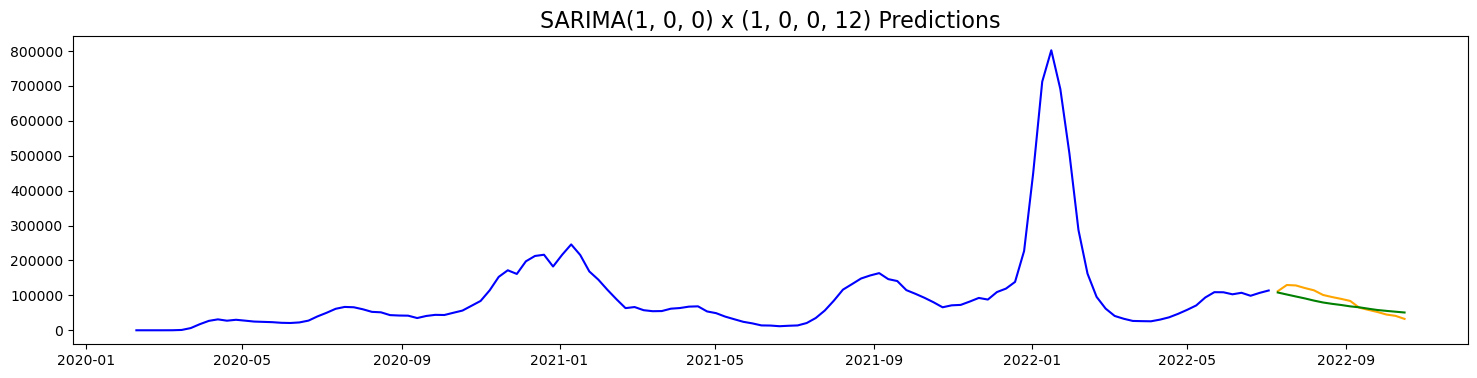

In [2148]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'SARIMA(1, 0, 0) x (1, 0, 0, 22) Predictions', fontsize=16)
plt.show();

## 3. Multivariate Time Series Models
____

In [2149]:
# Import VAR
from statsmodels.tsa.api import VAR

In [2150]:
df_var = pd.read_csv('../data/data_nc_VAR_Model.csv')
df_var = df_var.rename(columns={'submission_date': 'Date'})
df_var['Date'] = pd.to_datetime(df_var['Date'])
df_var.set_index('Date', inplace=True)
df_var.head(3)


,new_case,new_death,Admin_Dose_1_Daily,Administered_Dose1_Pop_Pct,Series_Complete_Daily,Series_Complete_Pop_Pct,Booster_Daily,Additional_Doses_Vax_Pct,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips >=500
Date,,,,,,,,,,,,
2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1853446.0,8634638.0,39155121.0,16466.0
2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1894941.0,8593143.0,38740334.0,18670.0
2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1864086.0,8623998.0,39691859.0,19378.0


In [2151]:

df_var = df_var.rename(columns={'Series_Complete_Daily': 'series_complete'})
df_var = df_var.rename(columns={'Number of Trips >=500': 'trips_500'})

In [2152]:
df_nc_var = df_var[['new_case', 'new_death', 'trips_500']] 

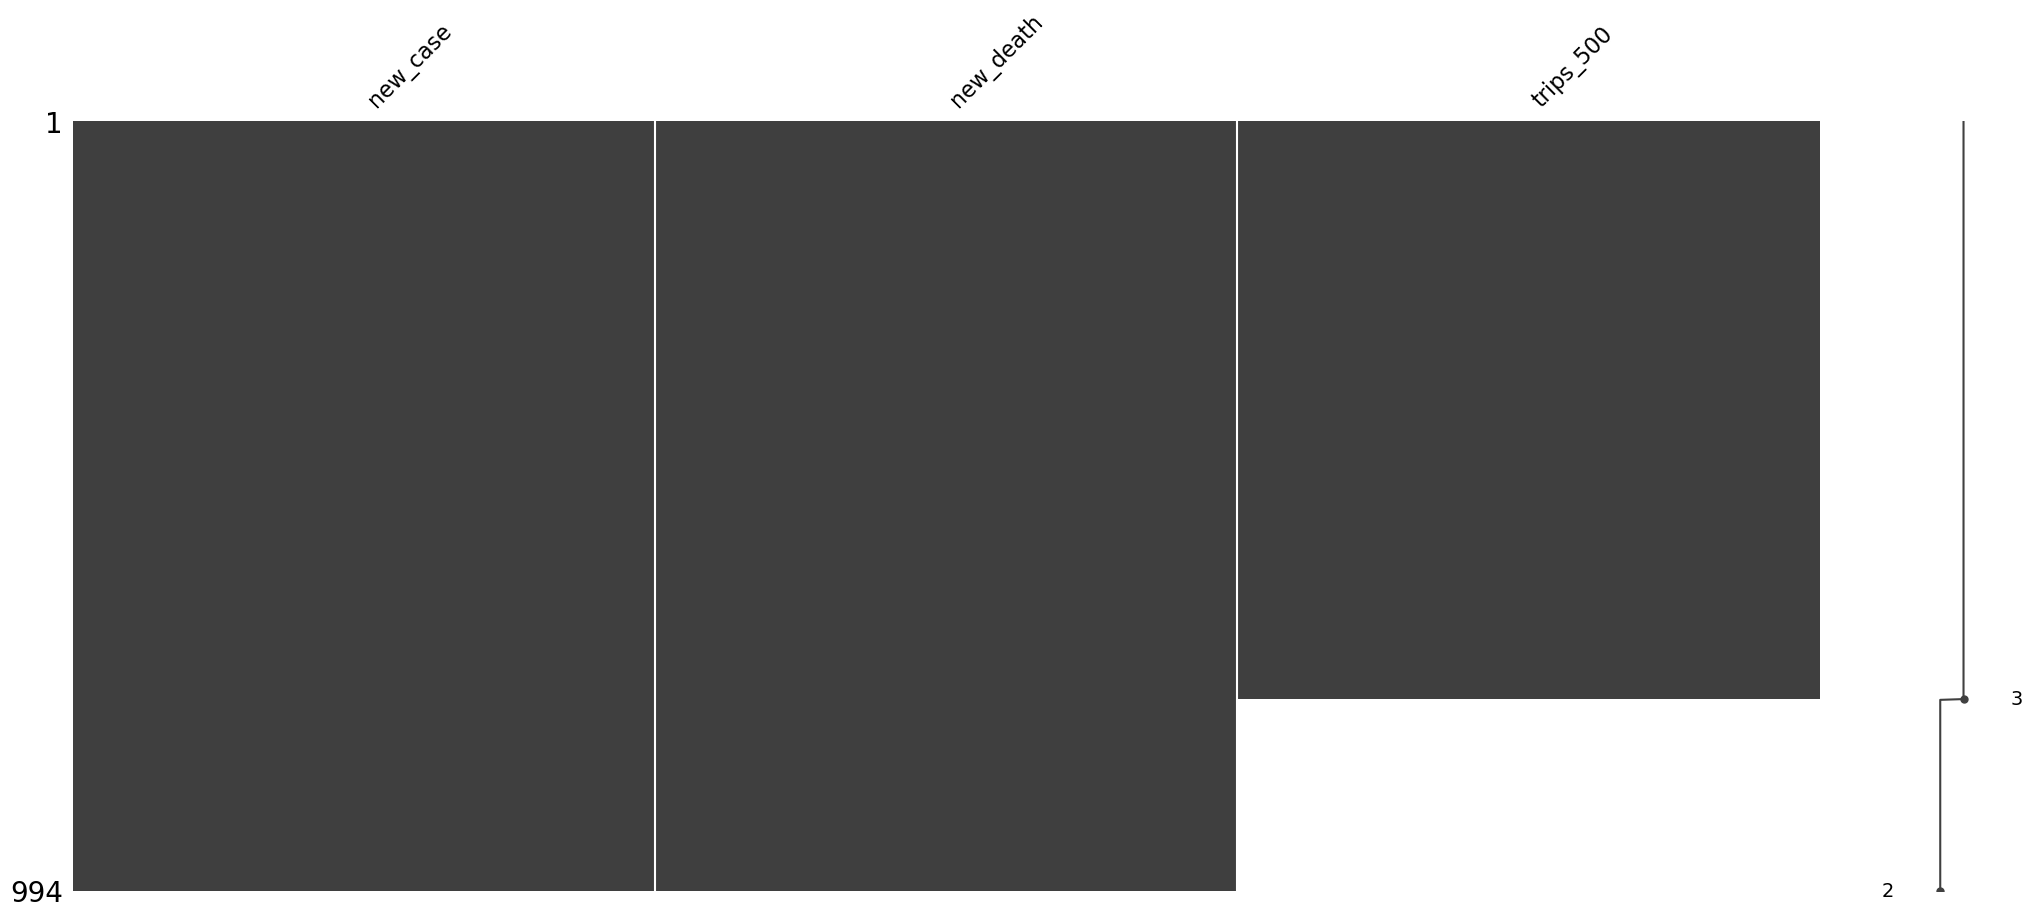

In [2153]:
msno.matrix(df_nc_var);

In [2154]:
df_nc_var.isnull().sum()

new_case       0
new_death      0
trips_500    248
dtype: int64

Filling not_at_home with max value because as vaccination happens not_at_home will increased slowly (life is backing to normal)

In [2155]:
#df_nc_var['trips_500'].fillna(df_nc_var['trips_500'].mode(), inplace=True)
df_nc_var.dropna(inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/2394585737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var.dropna(inplace=True)


In [2156]:
df_nc_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2020-01-22 to 2022-02-05
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_case   746 non-null    int64  
 1   new_death  746 non-null    int64  
 2   trips_500  746 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 23.3 KB


### Multivariante Model fo North Carolina
---

Since we are trying to focus in a state with higher covid cases and lower vaccination data (i.e North Carolina) we wil try to build a var model to predict new cases and check if the metric is acceptable for small legs  

In [2157]:
df_nc_var.head()

,new_case,new_death,trips_500
Date,,,
2020-01-22,0,0,16466.0
2020-01-23,0,0,18670.0
2020-01-24,0,0,19378.0
2020-01-25,0,0,17478.0
2020-01-26,0,0,19183.0


In [2158]:
df_nc_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 746 entries, 2020-01-22 to 2022-02-05
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_case   746 non-null    int64  
 1   new_death  746 non-null    int64  
 2   trips_500  746 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 23.3 KB


In [2159]:
df_nc_var.drop(df_nc_var[df_nc_var['new_case']==0].index, inplace=True)
df_nc_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-03-03 to 2022-02-05
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   new_case   699 non-null    int64  
 1   new_death  699 non-null    int64  
 2   trips_500  699 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 21.8 KB


/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Looking at TimeSeries Plot for the features
---

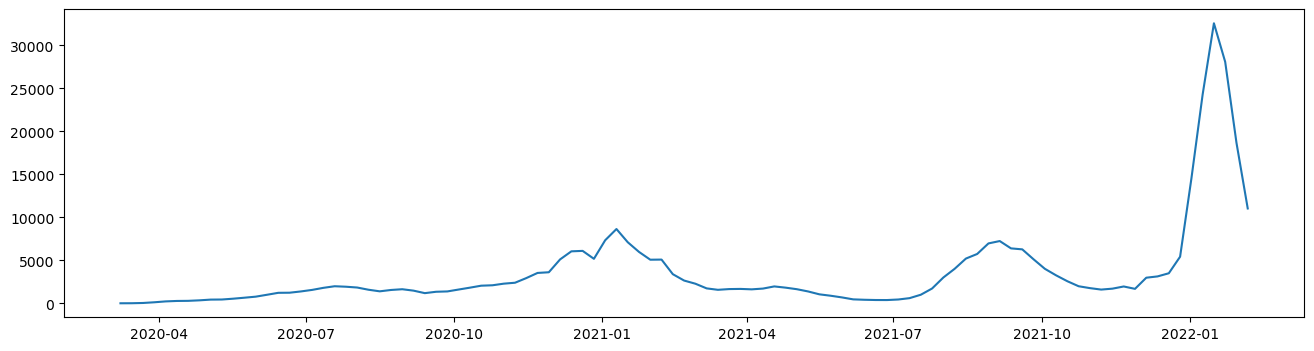

In [2160]:
plt.figure(figsize=(16,4))
plt.plot(df_nc_var['new_case'].resample('W').mean());

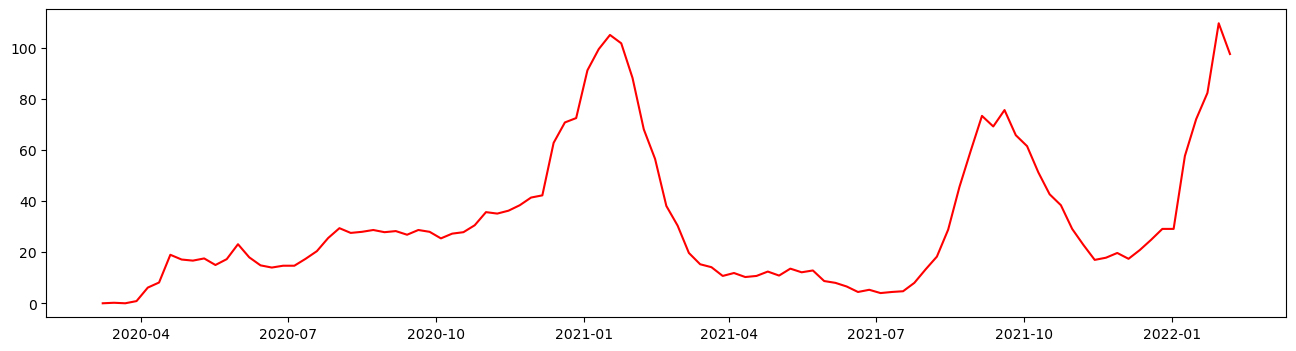

In [2161]:
plt.figure(figsize=(16,4))
plt.plot(df_nc_var['new_death'].resample('W').mean(), color='red');

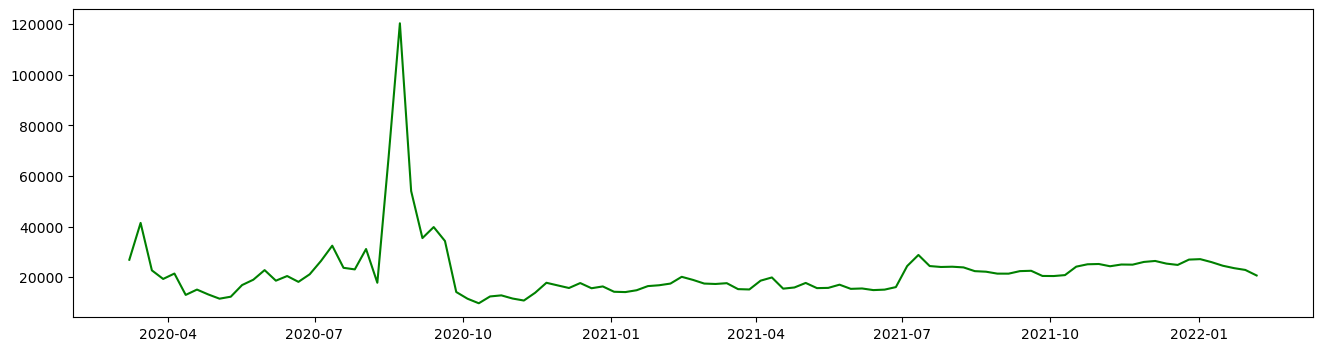

In [2162]:
plt.figure(figsize=(16,4))
plt.plot(df_nc_var['trips_500'].resample('W').mean(), color='green');

#### 1. Checking Stationarity

In [2164]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [2165]:
# Run ADF test on the original New Death data.
interpret_dftest(adfuller(df_nc_var['new_death']))

Test Statistic    -2.819421
p-value            0.055553
Lag Used          17.000000
dtype: float64

In [2166]:
# Run ADF test on the first-differcenced New Death data.
interpret_dftest(adfuller(df_nc_var['new_death'].diff().dropna()))


Test Statistic    -3.614011
p-value            0.005499
Lag Used          16.000000
dtype: float64

In [2167]:
# Create column.
df_nc_var['first_diff_new_death'] = df_nc_var['new_death'].diff()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/2047688624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var['first_diff_new_death'] = df_nc_var['new_death'].diff()


In [2168]:
df_nc_var.head(2)

,new_case,new_death,trips_500,first_diff_new_death
Date,,,,
2020-03-03,1,0,24011.0,NaN
2020-03-07,1,0,29765.0,0.0


Assuming $\alpha=0.01$, take two minutes to achieve stationarity for `new case` and `not_at_home`. If needed, create the columns we want to model.

In [2169]:
# Run ADF test on the original New Case data.
interpret_dftest(adfuller(df_nc_var['new_case']))

Test Statistic    -2.873279
p-value            0.048545
Lag Used          19.000000
dtype: float64

In [2170]:
# Run ADF test on the original first-differcenced New Case data.
interpret_dftest(adfuller(df_nc_var['new_case'].diff().dropna()))

Test Statistic    -5.069064
p-value            0.000016
Lag Used          20.000000
dtype: float64

In [2171]:
# Create column.
df_nc_var['first_diff_new_case'] = df_nc_var['new_case'].diff()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1583640008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var['first_diff_new_case'] = df_nc_var['new_case'].diff()


In [2172]:
# Run ADF test on the original trips_500 data.
interpret_dftest(adfuller(df_nc_var['trips_500']))

Test Statistic    -3.326031
p-value            0.013754
Lag Used          20.000000
dtype: float64

In [2173]:
df_nc_var.head(2)

,new_case,new_death,trips_500,first_diff_new_death,first_diff_new_case
Date,,,,,
2020-03-03,1,0,24011.0,NaN,NaN
2020-03-07,1,0,29765.0,0.0,0.0


#### 2. Train/test split.

In [2174]:
# Subset our data.
covid_df = df_nc_var[['first_diff_new_death', 'first_diff_new_case', 'trips_500']]

# Let's get rid of rows containing missing values.
covid_df.dropna(inplace = True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1972607083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df.dropna(inplace = True)


In [2175]:
train, test = train_test_split(covid_df,
                               test_size = 0.1,
                              shuffle=False)

In [2176]:
train.tail()

,first_diff_new_death,first_diff_new_case,trips_500
Date,,,
2021-11-23,-2.0,449.0,23911.0
2021-11-24,2.0,549.0,26750.0
2021-11-25,-6.0,-50.0,27928.0
2021-11-26,6.0,-678.0,26696.0
2021-11-27,-2.0,-494.0,26245.0


In [2177]:
test.head()

,first_diff_new_death,first_diff_new_case,trips_500
Date,,,
2021-11-28,10.0,472.0,26886.0
2021-11-29,-12.0,65.0,26885.0
2021-11-30,-4.0,821.0,25963.0
2021-12-01,3.0,964.0,25272.0
2021-12-02,4.0,462.0,25951.0


#### 3. Determine correct lag order $p$.

 We can automate the selection of $p$ using a metric called the Akaike information criterion, or the AIC. The AIC is a metric that is commonly used for time series models or in more "statistics-oriented" fields. We can actually find a good value of $p$ when we fit our model!

#### 4. Fit model.

In [2178]:
# Instantiate a VAR model. Remember that we pass
# our data in during instantiation in statsmodels!
model = VAR(train)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [2179]:
# Fit our model and use AIC to select the value of p.
ts_model = model.fit(maxlags = 15, # what is the largest possible value of p?
                 ic = 'aic')   # what "information criterion" (ic) will we use to decide what's "best?"

In [2180]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Oct, 2022
Time:                     12:10:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    34.2364
Nobs:                     614.000    HQIC:                   33.6689
Log likelihood:          -12710.2    FPE:                2.92208e+14
AIC:                      33.3078    Det(Omega_mle):     2.38507e+14
--------------------------------------------------------------------
Results for equation first_diff_new_death
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.065303         0.565795           -0.115           0.908
L1.first_diff_new_death         -0.784072         0.042048          -18.647           0.000
L

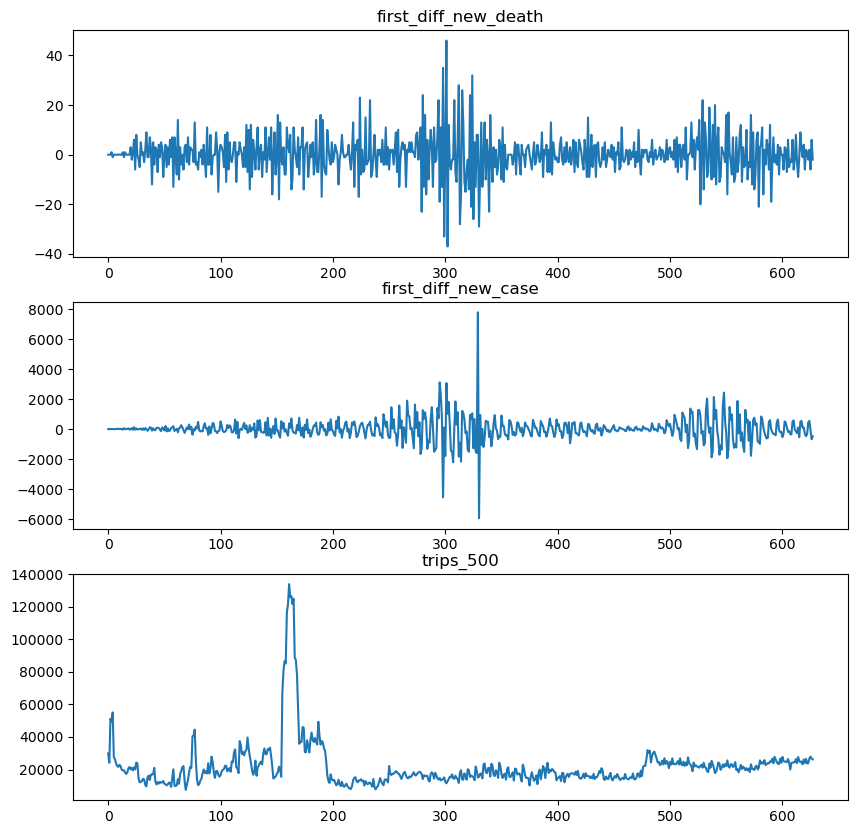

In [2181]:
# Plot our training data.
ts_model.plot();

#### 5. Generate forecasts.

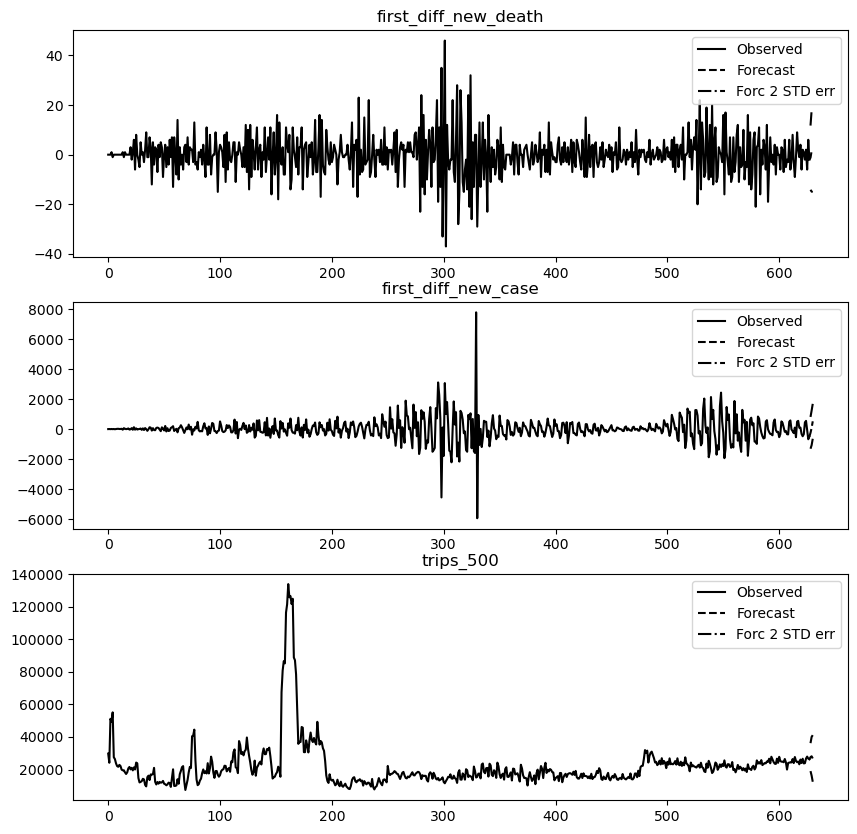

In [2182]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

In [2184]:
# Generate a forecast one step ahead.
ts_model.forecast(train.values, 1)

array([[-1.20994491e+00, -2.49880645e+02,  2.76019663e+04]])

In [2185]:
# Generate a forecast five steps ahead.
ts_model.forecast(train.values, 5)

array([[-1.20994491e+00, -2.49880645e+02,  2.76019663e+04],
       [ 1.49215039e+00,  8.31937701e+01,  2.81278375e+04],
       [ 1.36426820e+00,  5.19512755e+02,  2.67858209e+04],
       [-4.83163533e-01,  5.15574582e+02,  2.63509753e+04],
       [-2.49990939e+00, -1.81769158e+01,  2.59999347e+04]])

In [2186]:
test.shape

(70, 3)

In [2187]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, test.shape[0])

array([[-1.20994491e+00, -2.49880645e+02,  2.76019663e+04],
       [ 1.49215039e+00,  8.31937701e+01,  2.81278375e+04],
       [ 1.36426820e+00,  5.19512755e+02,  2.67858209e+04],
       [-4.83163533e-01,  5.15574582e+02,  2.63509753e+04],
       [-2.49990939e+00, -1.81769158e+01,  2.59999347e+04],
       [ 4.46749584e-01, -2.77301922e+02,  2.68853324e+04],
       [-1.72585956e+00, -4.51712164e+02,  2.64178034e+04],
       [ 2.33079387e-01, -3.46145796e+02,  2.54659210e+04],
       [ 3.12754681e-01,  2.21134769e+01,  2.47204210e+04],
       [ 5.88890631e-01,  4.45873466e+02,  2.46080466e+04],
       [ 1.51730452e-01,  4.13578378e+02,  2.44045802e+04],
       [-1.64609832e+00,  5.75059144e+01,  2.41463295e+04],
       [ 3.97221960e-01, -2.86590331e+02,  2.43602799e+04],
       [-3.90469470e-01, -4.06580100e+02,  2.46241370e+04],
       [ 1.84512393e-01, -2.55713567e+02,  2.45764696e+04],
       [ 2.78239593e-01,  6.97094026e+01,  2.42590540e+04],
       [ 2.15012712e-01,  3.55785821e+02

#### 6. Evaluate model (and forecasts, if possible).

In [2188]:
# We'll use MSE
from sklearn.metrics import mean_squared_error, r2_score

In [2189]:
# Save forecasted values
forecast = ts_model.forecast(train.values, test.shape[0])

In [2190]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the first_diff_new_death data is: 131.4485
The test MSE on the first_diff_new_case data is: 20630275.4318
The test MSE on the trips_500 data is: 7333887.0672


In [2191]:
# Loop through columns and get R2 for each
for i in range(test.shape[1]):
    print(f'The test R2 on the {test.columns[i]} data is: {round(r2_score(test.values[:, i], forecast[:, i]), 4)}')

The test R2 on the first_diff_new_death data is: -0.0392
The test R2 on the first_diff_new_case data is: 0.0328
The test R2 on the trips_500 data is: -0.4614


## 4. Exogenous Time series Models 
____

In [2192]:
df_var.head()

,new_case,new_death,Admin_Dose_1_Daily,Administered_Dose1_Pop_Pct,series_complete,Series_Complete_Pop_Pct,Booster_Daily,Additional_Doses_Vax_Pct,Population Staying at Home,Population Not Staying at Home,Number of Trips,trips_500
Date,,,,,,,,,,,,
2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1853446.0,8634638.0,39155121.0,16466.0
2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1894941.0,8593143.0,38740334.0,18670.0
2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1864086.0,8623998.0,39691859.0,19378.0
2020-01-25,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2049145.0,8438939.0,38065676.0,17478.0
2020-01-26,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2175018.0,8313066.0,33393079.0,19183.0


In [2193]:
df_nc_var_ex = df_var[[ 'new_death', 'new_case', 'trips_500', 'series_complete']] 

<AxesSubplot:>

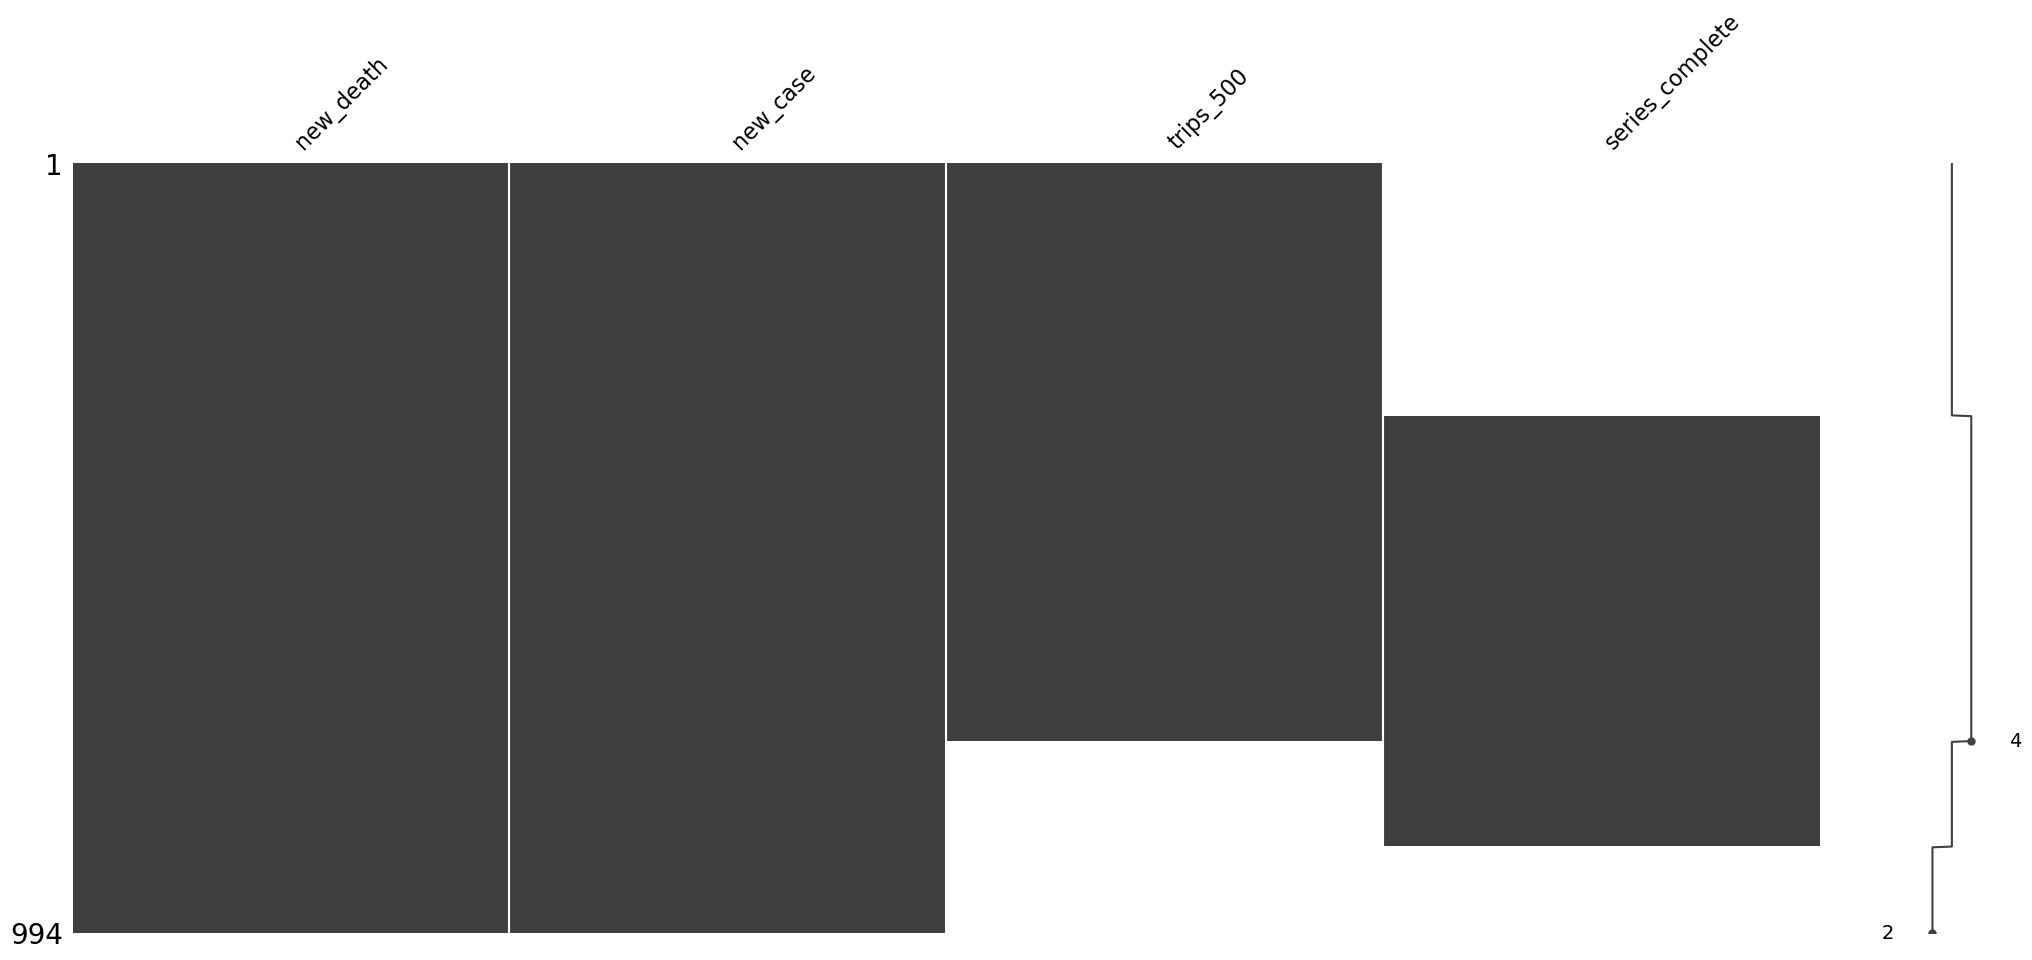

In [2194]:
msno.matrix(df_nc_var_ex)

In [2195]:
df_nc_var_ex['series_complete'].fillna(0, inplace=True)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2196]:
df_nc_var_ex.dropna(inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1797246450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_var_ex.dropna(inplace=True)


In [2197]:
df_nc_var_ex.head()

,new_death,new_case,trips_500,series_complete
Date,,,,
2020-01-22,0,0,16466.0,0.0
2020-01-23,0,0,18670.0,0.0
2020-01-24,0,0,19378.0,0.0
2020-01-25,0,0,17478.0,0.0
2020-01-26,0,0,19183.0,0.0


In [2198]:
df_nc_var_ex = df_nc_var_ex.resample('W').mean()

#### 1. Stationarity

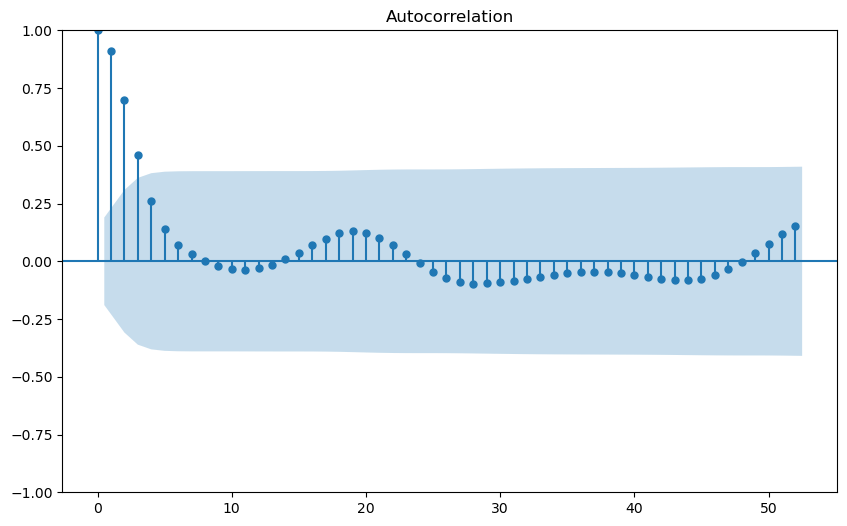

In [2199]:
# Generate the ACF plot on Weekly Sales data up to 52 time periods.
plt.rc("figure", figsize=(10,6))
plot_acf(df_nc_var_ex['new_case'], lags = 52);

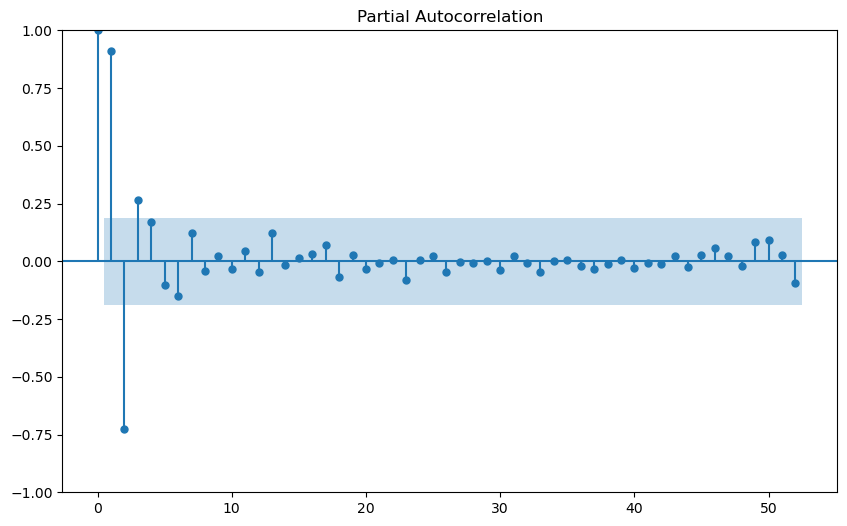

In [2200]:
plt.rc("figure", figsize=(10,6))
plot_pacf(df_nc_var_ex['new_case'],lags = 52, method='ywm' );

In [2201]:
# Run ADF test on the original New Death data.
interpret_dftest(adfuller(df_nc_var_ex['new_death']))


Test Statistic   -2.760576
p-value           0.064130
Lag Used          4.000000
dtype: float64

In [2202]:
# Run ADF test on the first-differcenced New Death data.
interpret_dftest(adfuller(df_nc_var_ex['new_death'].diff().dropna()))

Test Statistic   -4.577776
p-value           0.000142
Lag Used          3.000000
dtype: float64

In [2203]:
# Create column.
df_nc_var_ex['first_diff_new_death'] = df_nc_var_ex['new_death'].diff()

In [2204]:
# Run ADF test on the original vaccination data.
interpret_dftest(adfuller(df_nc_var_ex['series_complete']))

Test Statistic   -1.930462
p-value           0.317869
Lag Used          2.000000
dtype: float64

In [2205]:
# Run ADF test on the first-differcenced vaccination data.
interpret_dftest(adfuller(df_nc_var_ex['series_complete'].diff().dropna()))

Test Statistic   -1.088934e+01
p-value           1.236545e-19
Lag Used          1.000000e+00
dtype: float64

In [2206]:
# Create column.
df_nc_var_ex['first_diff_series_complete'] = df_nc_var_ex['series_complete'].diff()

In [2207]:
df_nc_var_ex.head()

,new_death,new_case,trips_500,series_complete,first_diff_new_death,first_diff_series_complete
Date,,,,,,
2020-01-26,0.0,0.0,18235.000000,0.0,NaN,NaN
2020-02-02,0.0,0.0,27296.714286,0.0,0.0,0.0
2020-02-09,0.0,0.0,37184.714286,0.0,0.0,0.0
2020-02-16,0.0,0.0,55274.285714,0.0,0.0,0.0
2020-02-23,0.0,0.0,45274.428571,0.0,0.0,0.0


In [2208]:
df_nc_var_ex.dropna(inplace=True)

In [2209]:
df_nc_var_ex = df_nc_var_ex[['first_diff_new_death','first_diff_series_complete']]

In [2210]:
df_nc_var_ex.head()

,first_diff_new_death,first_diff_series_complete
Date,,
2020-02-02,0.0,0.0
2020-02-09,0.0,0.0
2020-02-16,0.0,0.0
2020-02-23,0.0,0.0
2020-03-01,0.0,0.0


In [2211]:
train, test = train_test_split(df_nc_var_ex,
                               test_size = 0.1,
                              shuffle=False)

In [2212]:
# check train
train.tail()

,first_diff_new_death,first_diff_series_complete
Date,,
2021-10-24,-4.285714,-734.857143
2021-10-31,-9.285714,-2949.857143
2021-11-07,-6.285714,1625.571429
2021-11-14,-5.857143,-4334.428571
2021-11-21,0.857143,198.857143


In [2213]:
test.head()

,first_diff_new_death,first_diff_series_complete
Date,,
2021-11-28,1.857143,-1875.142857
2021-12-05,-2.285714,15798.000000
2021-12-12,3.428571,-3108.428571
2021-12-19,4.000000,-4823.000000
2021-12-26,4.285714,-4242.285714


In [2214]:
train.shape

(95, 2)

In [2215]:
test.shape

(11, 2)

In [2216]:
# Fit and visualize a SARIMAX(1, 1, 0) x (2, 0, 0, 22) model.

sarima = SARIMAX(endog = train['first_diff_new_death'].iloc[1:],
                 order = (1, 1, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 22), # (P, D, Q, S)
                 exog = train['first_diff_series_complete'].iloc[1:])

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 186.
preds = model.predict(start=1, end=11, exog=test[['first_diff_series_complete']])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04774D+00    |proj g|=  1.26176D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     40      2     0     0   5.122D-03   3.047D+00
  F =   3.0467753460643445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [2217]:
# Evaluate predictions.
print(mean_squared_error(test['first_diff_new_death'].iloc[0:], preds))

186.3684407960456


In [2218]:
preds

Date
2020-02-16    0.000000
2020-02-23    0.000000
2020-03-01    0.000000
2020-03-08    0.000000
2020-03-15    0.000000
2020-03-22    0.081257
2020-03-29   -0.019657
2020-04-05    0.425943
2020-04-12    3.376117
2020-04-19    3.416798
2020-04-26    7.037948
Freq: W-SUN, Name: predicted_mean, dtype: float64

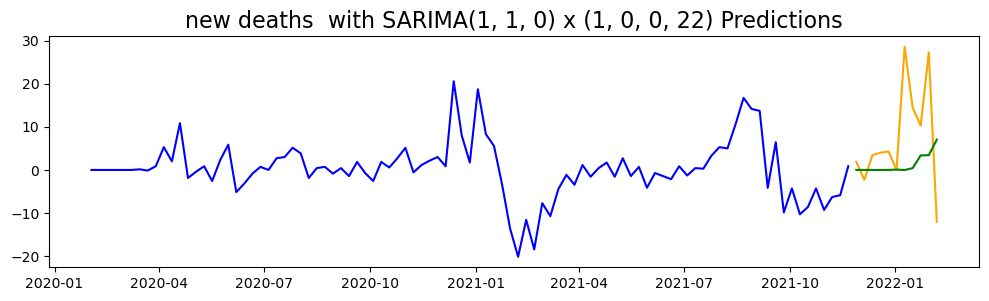

In [2219]:
# Plot data.
plt.figure(figsize=(12,3))
plt.plot(train['first_diff_new_death'], color = 'blue')
plt.plot(test['first_diff_new_death'], color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = 'new deaths  with SARIMAX(1, 1, 0) x (1, 0, 0, 22) Predictions', fontsize=16)
plt.show();

## 5. TimeseriesGenerator with RNN Models
____

In [2220]:
df_var.columns

Index(['new_case', 'new_death', 'Admin_Dose_1_Daily',
       'Administered_Dose1_Pop_Pct', 'series_complete',
       'Series_Complete_Pop_Pct', 'Booster_Daily', 'Additional_Doses_Vax_Pct',
       'Population Staying at Home', 'Population Not Staying at Home',
       'Number of Trips', 'trips_500'],
      dtype='object')

In [2221]:
df_rnn =  df_var[['new_case', 'new_death', 'series_complete','trips_500']] 

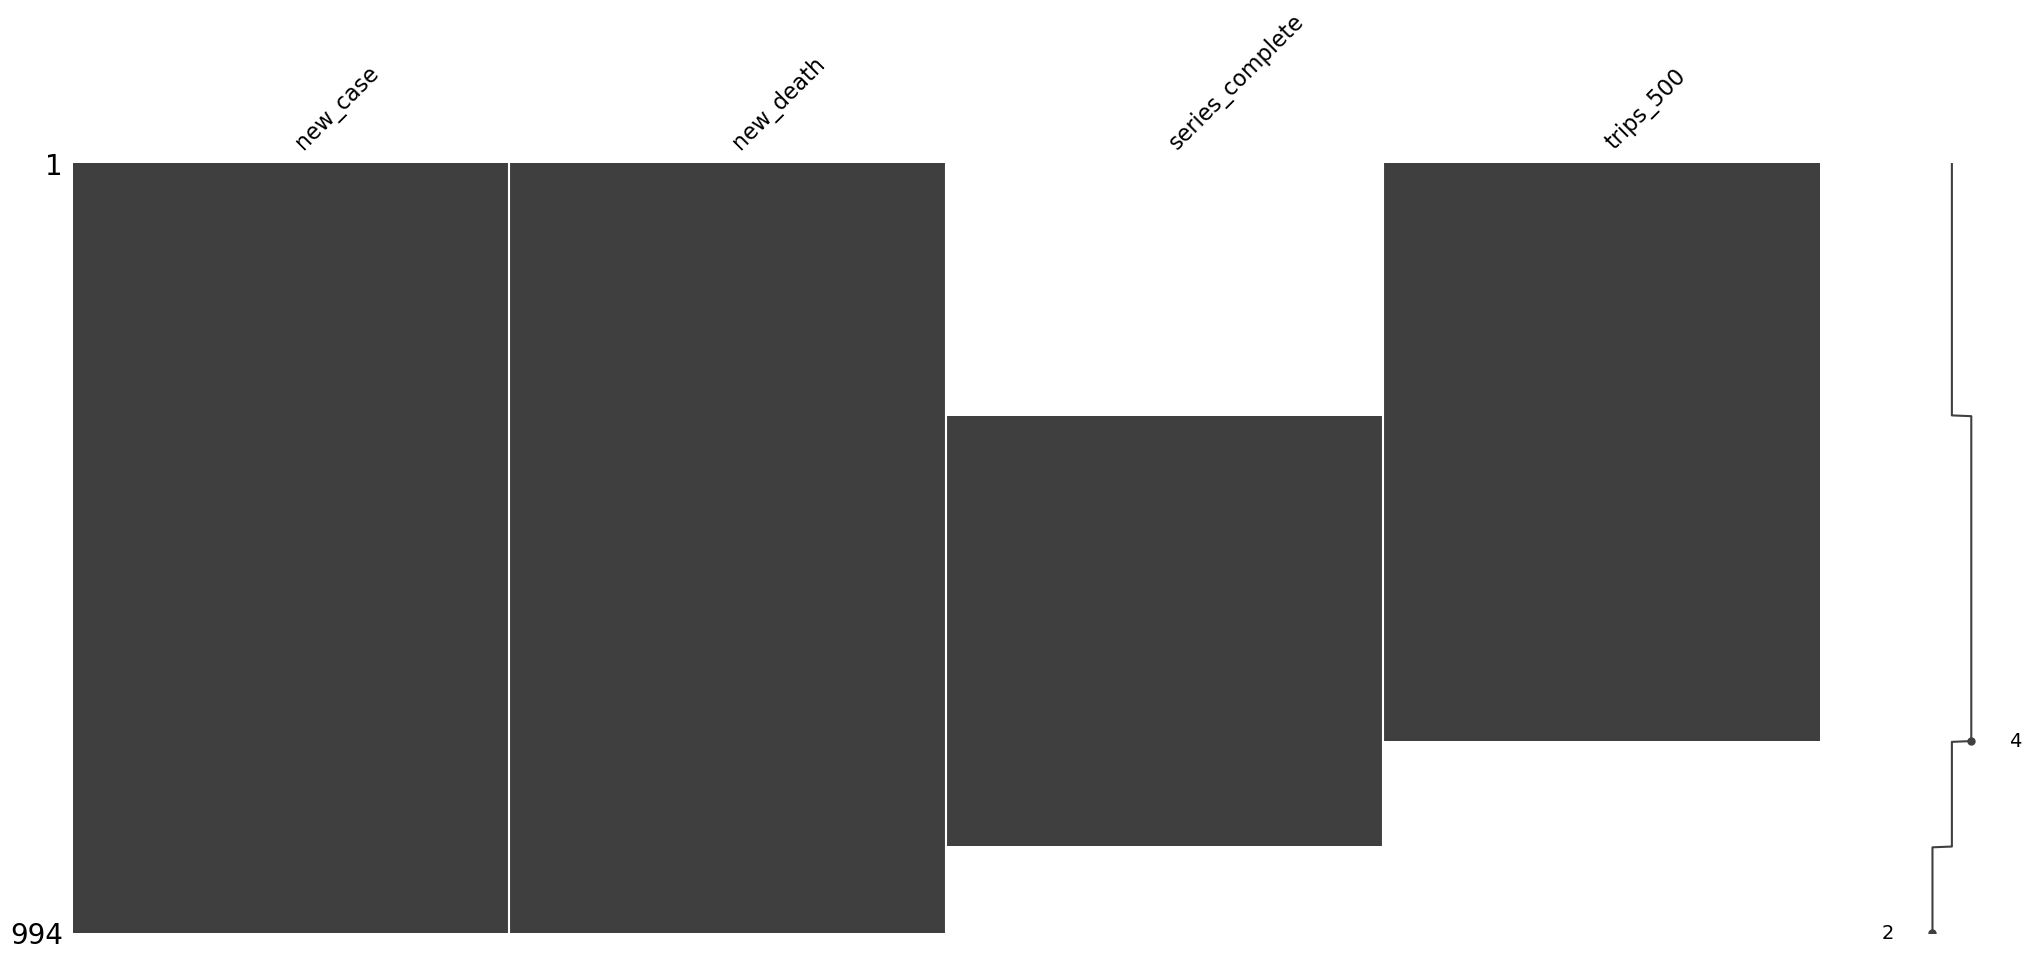

In [2222]:
msno.matrix(df_rnn);

In [2223]:
df_rnn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2020-01-22 to 2022-10-11
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   new_case         994 non-null    int64  
 1   new_death        994 non-null    int64  
 2   series_complete  556 non-null    float64
 3   trips_500        746 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 38.8 KB


In [2224]:
# Putting zeros before vaccination started
df_rnn.loc['2020-01-22':'2022-01-01'].fillna(0,inplace=True)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2225]:
# The number of trips it will not decrease as vaccination ia avaiable and life is backing to normal
df_rnn['trips_500'].fillna(df_nc_var['trips_500'].mean(), inplace=True)

/Users/silviaresende/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [2226]:
df_rnn.dropna(inplace=True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/3260562871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn.dropna(inplace=True)


### Stationarity

In [2227]:
# Run ADF test on the original data.
interpret_dftest(adfuller(df_rnn['new_case']))

Test Statistic    -3.846602
p-value            0.002465
Lag Used          21.000000
dtype: float64

In [2228]:
# Run ADF test on the originaldata.
interpret_dftest(adfuller(df_rnn['new_death']))

Test Statistic    -4.420095
p-value            0.000273
Lag Used          21.000000
dtype: float64

In [2229]:
# Run ADF test on the original data.
interpret_dftest(adfuller(df_rnn['series_complete']))

Test Statistic    -2.916328
p-value            0.043482
Lag Used          13.000000
dtype: float64

In [2230]:
# Run ADF test on the differenced-once data.
interpret_dftest(adfuller(df_rnn['series_complete'].diff().dropna()))

Test Statistic   -1.070019e+01
p-value           3.539560e-19
Lag Used          2.000000e+01
dtype: float64

In [2231]:
df_rnn['diff_first_series'] = df_rnn['series_complete'].diff()

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/1585055248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn['diff_first_series'] = df_rnn['series_complete'].diff()


In [2232]:
# Run ADF test on the originaldata.
interpret_dftest(adfuller(df_rnn['trips_500']))

Test Statistic    -4.363856
p-value            0.000344
Lag Used          21.000000
dtype: float64

In [2233]:
df_rnn.head()

,new_case,new_death,series_complete,trips_500,diff_first_series
Date,,,,,
2020-01-22,0,0,0.0,16466.0,NaN
2020-01-23,0,0,0.0,18670.0,0.0
2020-01-24,0,0,0.0,19378.0,0.0
2020-01-25,0,0,0.0,17478.0,0.0
2020-01-26,0,0,0.0,19183.0,0.0


In [2234]:
# Subset our data.
df_nc_rnn = df_rnn[['new_death','new_case', 'diff_first_series', 'trips_500']]

# Let's get rid of rows containing missing values.
df_nc_rnn.dropna(inplace = True)

/var/folders/l8/cflxs4pj1h362zjpxchj9jd00000gn/T/ipykernel_10816/2318484015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nc_rnn.dropna(inplace = True)


In [2235]:
df_nc_rnn.head()

,new_death,new_case,diff_first_series,trips_500
Date,,,,
2020-01-23,0,0,0.0,18670.0
2020-01-24,0,0,0.0,19378.0
2020-01-25,0,0,0.0,17478.0
2020-01-26,0,0,0.0,19183.0
2020-01-27,0,0,0.0,18608.0


In [2236]:
X = df_nc_rnn[['new_case']]#,'diff_first_series','trips_500']]
y = df_nc_rnn[['new_death']].values

In [2237]:
X.head()

,new_case
Date,
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
2020-01-27,0


In [2238]:
y

array([[  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  1],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  0],
       [  1],
       [  0],
       [  1],
       [  1],
       [  1],
       [  1],
       [  1],
       [  4],
       [  2],
       [  3],
       [  9],
      

In [2239]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

In [2240]:
X_train.tail()

,new_case
Date,
2021-11-08,1003
2021-11-09,1495
2021-11-10,2073
2021-11-11,2048
2021-11-12,1911


In [2241]:
X_test.head()

,new_case
Date,
2021-11-13,1645
2021-11-14,1745
2021-11-15,1205
2021-11-16,1705
2021-11-17,2253


### Scaling


You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [2242]:
# Scale
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [2243]:
X_train_sc.shape

(660, 1)

## TimesSeries Generator
____

In [2244]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 3, batch_size = 64)

In [2245]:
batch_x, batch_y = train_sequences[0]

print(batch_x.shape)
print(batch_y.shape)

(64, 3, 1)
(64, 1)


In [2246]:
# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 3, batch_size = 64)

## Modeling 
---

designing our RNN model:

- 2 `GRU` layers
- 1 `Dense` output layer

We're doing a regression problem.

In [2247]:
train_sequences[0][0].shape

(64, 3, 1)

In [2248]:
# input shape
input_shape = train_sequences[0][0][0].shape
train_sequences[0][0][0].shape

(3, 1)

In [2249]:
# Design RNN
model = Sequential()
model.add(GRU(8, input_shape = input_shape, return_sequences = True)) # True when next layer is RNN
model.add(GRU(8, return_sequences = False)) # False if next layer is Dense
model.add(Dense(4, activation = 'relu'))
# output layer
model.add(Dense(1, activation = 'linear'))

In [2250]:
model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.0005),
              metrics = ['acc'])

history = model.fit(train_sequences,
                    validation_data = test_sequences,
                    epochs = 100)

Epoch 1/100


2022-10-23 12:10:34.959902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:35.191026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:35.241066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:35.339745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/11 [=======>......................] - ETA: 0s - loss: 2724.2036 - acc: 0.2969

2022-10-23 12:10:35.439608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1474.0753 - acc: 0.0883

2022-10-23 12:10:36.031505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:36.094564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 12:10:36.133123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 2s 78ms/step - loss: 1474.0753 - acc: 0.0883 - val_loss: 1892.9106 - val_acc: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 0s 24ms/step - loss: 1471.0593 - acc: 0.0883 - val_loss: 1889.5620 - val_acc: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 1466.9474 - acc: 0.0883 - val_loss: 1886.2871 - val_acc: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 0s 19ms/step - loss: 1463.1646 - acc: 0.0883 - val_loss: 1882.5170 - val_acc: 0.0000e+00
Epoch 5/100
11/11 [==============================] - 0s 19ms/step - loss: 1460.4900 - acc: 0.0883 - val_loss: 1876.5665 - val_acc: 0.0000e+00
Epoch 6/100
11/11 [==============================] - 0s 19ms/step - loss: 1454.8442 - acc: 0.0883 - val_loss: 1872.1744 - val_acc: 0.0000e+00
Epoch 7/100
11/11 [==============================] - 0s 19ms/step - loss: 1450.4312 - acc: 0.0883 - val_loss: 1866.8948 - val_acc: 0.0000e+00
Epoch 8/100
11/11 

In [ ]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend();

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model2 = Sequential()

model2.add(GRU(64, input_shape = (3, 8), return_sequences = True))
model2.add(Dropout(0.5))
model2.add(GRU(32, return_sequences = True))
model2.add(Dropout(0.5))
model2.add(GRU(16, return_sequences = False))
model2.add(Dropout(0.5))

model2.add(Dense(128, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dense(1, activation = 'linear'))

model2.compile(optimizer = Adam(learning_rate = 0.001),
               loss = 'mse',
               metrics = ['acc'])

es = EarlyStopping(patience = 15)

history2 = model2.fit(train_sequences, epochs = 100, validation_data = test_sequences,
                      callbacks = [es], verbose = 0)

In [ ]:
plt.plot(history2.history['loss'], label = 'Train loss')
plt.plot(history2.history['val_loss'], label = 'Test loss')
plt.legend();

In [ ]:
pd.DataFrame(history2.history).plot(figsize = (12, 6))

print(model2.evaluate(test_sequences))

In [ ]:
print('The End!')

______

`NOTE: This Section is basically experimental. Since we could not find trends/seasonality on the data, all time series model perform very bad. ARIMA/SARIMA/SARIMAX/VAR/TimesGeneratorRNN Models were used to modeling it. According to some experts in epidemiology, in the future the covid will become seasonal like the flu and if that happens this model can be used for further analysis and prediction.` \ 
`**Remember**:this is a learning enviroment and we are encouraged to try things! :] )`
